# Verifying Volunteer Entries to the NYC Trees Census
## Data Exploration, Modeling, and Results

## Table of contents
1. [Introduction](#Introduction)
2. [The problem domain](#The-problem-domain)
3. [Required libraries](#Required-libraries)
4. [Step 1: Answering the initial questions](#Step-1:-Answering-the-initial-questions)
5. [Step 2: Checking the data](#Step-2:-Checking-the-data)
6. [Step 3: Cleaning the data](#Step-3:-Cleaning-the-data)
7. [Step 4: Exploratory analysis and feature engineering](#Step-4:-Exploratory-analysis-and-feature-engineering)
8. [Vanilla models interruption](#Vanilla-models-interruption)
9. [Finishing dummy columns](#Finishing-dummy-columns)
10. [Step 5: Classification](#Step-5:-Classification)

Cross-validation

Parameter tuning

Step 6: Reproducibility

Conclusions

Further reading

Acknowledgements



## Cleaning and exploring the data
- **Import the necessary libraries.**

## Introduction
[[go back to the top](#Verifying-Volunteer-Entries-to-the-NYC-Trees-Census)]

Using NYC Open Data's [2015 Street Tree Census Data Set](https://data.cityofnewyork.us/Environment/2015-Street-Tree-Census-Tree-Data/pi5s-9p35) (to download the dataset, click **Export** for the non-geospatial version), I will explore the significance of certain variables on the health of the street trees in New York City. Using these findings, I will then create a classification model to gain further insights into which factors play a role in a tree's health. Another goel of the model will be to use it as a means of verifying the health status imputed by volunteers.

## The problem domain
[[go back to the top](#Verifying-Volunteer-Entries-to-the-NYC-Trees-Census)]

The New York City Department of Parks and Recreation would like to use its current data to bolster or modify their environmental policy agenda while also looking for ways to improve their data collection for the next tree census in 2025. There is also some interest within the department to compare data collected by professional staff (members of the Parks Department and TreesCount) with that collected by volunteers. 

The department has tasked me with the following:

- Identify factors that contribute to the health status of a tree.
- Create suggestions for improving future censuses.
- Build a model that can predict a tree's health status, to verify the status determined by volunteers.

## Required libraries
[[go back to the top](#Verifying-Volunteer-Entries-to-the-NYC-Trees-Census)]

This notebook uses several Python packages that come standard with the Anaconda Python distribution. The primary libraries that we'll be using are:

- **NumPy**: Provides a fast numerical array structure and helper functions.
- **pandas**: Provides a DataFrame structure to store data in memory and work with it easily and efficiently.
- **scikit-learn**: The essential Machine Learning package in Python.
- **SciPy**: The essential statistical analysis package in Python.
- **matplotlib**: Basic plotting library in Python; most other Python plotting libraries are built on top of it.
- **Seaborn**: Advanced statistical plotting library.
- **warnings**: A helpful package to ignore warnings that unnecessarily clutter the notebook.
- **watermark**: A Jupyter Notebook extension for printing timestamps, version numbers, and hardware information.

This notebook also uses some additional packages that you may have to install:

- **GeoPandas**: Provides a specialized GeoDataFrame structure to more easily analyze locational data.
- **functions**: Custom functions that I built for this project (included by cloning this project's repo).

Run the cell below to import all of the necessary libraries.

In [1]:
# dataframe libraries
import pandas as pd
import numpy as np
import geopandas as gpd

# visualizations libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style('ticks')

# custom functions, reloading when updated
from functions import *
%load_ext autoreload
%autoreload 2

# ignore sklearn warnings (code from: https://stackoverflow.com/questions/32612180/eliminating-warnings-from-scikit-learn)
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

# statistical tests
from scipy import stats
import statsmodels.api as sm

# modeling libraries
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, make_scorer, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# saving libraries
import pickle
import gzip

## Step 1: Answering some initial questions
[[go back to the top](#Verifying-Volunteer-Entries-to-the-NYC-Trees-Census)]

**Where does the data come from?**

The data was collected by New York City Department of Parks and Recreation staff, TreesCount staff, and volunteers. It was made public by NYC Open Data. 

**What do the variables mean in actual language?**

Variables in plain English are provided in the [Variable Descriptions](census_variable_descriptions.pdf) file within the project's repo.

**What is the target variable?**

The target variable is the health status of a tree--Good, Fair, or Poor.

Note: stumps and dead trees are included, but were not used in this project.
    
**What is the range, scale, or distribution of each variable?**

All variables, other than tree diameter, are categorical.
Tree diameter ranges from 0 and 425 inches and is positively skewed.
    
**What elements of the data will or will not address the business question?**

I will be exploring tree diameter, species, observances of tree stewardship, presence of tree guards and whether they are helpful or harmful, condition of sidewalk, problems in the roots or trunks or branches, location within the city (most likely using borough and neighborhood).
    
**Are there any issues related to data permissions, copyright, ethical issues, confidential information, etc.?**

No.
    
**Are there any interesting aspects or anomalies in the data such as outliers or missing data?**

The target variable has a notable class imbalance. 82% of trees are listed as Good, 14% are Fair, and 4% are Poor.

The data looks fairly complete and has very few NaN values, especially after dropping stumps and dead trees.

Tree diameter does have some outliers that I will have to adjust.
    
**What additional data would be really helpful to your analysis?**

Date the tree was planted (i.e. age of the tree), if known, as well as more specificity regarding root, trunk, or branch problems. I will go into more detail on these during EDA.

**Did you specify the type of data analytic question (e.g. exploration, association causality) before touching the data?**

This will be an exploration, feature engineering, and classification project.

**Did you define the metric for success before beginning?**

To help account for there being such a large majority class, I will use F1 score as that is the most complete measure of false predictions and doesn't overemphasize models that simply predict the majority class.

Note: I will eventually see that a custom metric of the precision of Good predictions will help me find a model that is decently spread out among all the classes.

## Step 2: Checking the data
[[go back to the top](#Verifying-Volunteer-Entries-to-the-NYC-Trees-Census)]

I'll import the raw data and look for anything strange or missing.

In [2]:
trees_initial = pd.read_csv('data/2015StreetTreesCensus_TREES.csv')
trees_initial.head()

,created_at,tree_id,block_id,the_geom,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,...,st_assem,st_senate,nta,nta_name,boro_ct,state,Latitude,longitude,x_sp,y_sp
0,08/27/2015,180683,348711,POINT (-73.84421521958048 40.723091773924274),3,0,OnCurb,Alive,Fair,Acer rubrum,...,28,16,QN17,Forest Hills,4073900,New York,40.723092,-73.844215,1.027431e+06,202756.768749
1,09/03/2015,200540,315986,POINT (-73.81867945834878 40.79411066708779),21,0,OnCurb,Alive,Fair,Quercus palustris,...,27,11,QN49,Whitestone,4097300,New York,40.794111,-73.818679,1.034456e+06,228644.837379
2,09/05/2015,204026,218365,POINT (-73.93660770459083 40.717580740099116),3,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,...,50,18,BK90,East Williamsburg,3044900,New York,40.717581,-73.936608,1.001823e+06,200716.891267
3,09/05/2015,204337,217969,POINT (-73.93445615919741 40.713537494833226),10,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,...,53,18,BK90,East Williamsburg,3044900,New York,40.713537,-73.934456,1.002420e+06,199244.253136
4,08/30/2015,189565,223043,POINT (-73.97597938483258 40.66677775537875),21,0,OnCurb,Alive,Good,Tilia americana,...,44,21,BK37,Park Slope-Gowanus,3016500,New York,40.666778,-73.975979,9.909138e+05,182202.425999


In [3]:
trees_initial.shape

(683788, 42)

In [4]:
trees_initial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683788 entries, 0 to 683787
Data columns (total 42 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   created_at  683788 non-null  object 
 1   tree_id     683788 non-null  int64  
 2   block_id    683788 non-null  int64  
 3   the_geom    683788 non-null  object 
 4   tree_dbh    683788 non-null  int64  
 5   stump_diam  683788 non-null  int64  
 6   curb_loc    683788 non-null  object 
 7   status      683788 non-null  object 
 8   health      652172 non-null  object 
 9   spc_latin   652169 non-null  object 
 10  spc_common  652169 non-null  object 
 11  steward     652173 non-null  object 
 12  guards      652172 non-null  object 
 13  sidewalk    652172 non-null  object 
 14  user_type   683788 non-null  object 
 15  problems    652124 non-null  object 
 16  root_stone  683788 non-null  object 
 17  root_grate  683788 non-null  object 
 18  root_other  683788 non-null  object 
 19  tr

There are some null values that I'll have to address, but I wonder if dropping stumps and dead trees will take care of a lot of those. It certainly looks like most variables have non-null data that is near the number of 'Alive' trees (see cell below).

Some of the column names could be clearer as well, so I'll go ahead and rename them in the next section.

In [5]:
trees_initial.status.value_counts()

Alive    652173
Stump     17654
Dead      13961
Name: status, dtype: int64

In [6]:
# look at the numerical data
trees_initial.describe()

,tree_id,block_id,tree_dbh,stump_diam,zipcode,cb_num,borocode,cncldist,st_assem,st_senate,boro_ct,Latitude,longitude,x_sp,y_sp
count,683788.000000,683788.000000,683788.000000,683788.000000,683788.000000,683788.000000,683788.000000,683788.000000,683788.000000,683788.000000,6.837880e+05,683788.000000,683788.000000,6.837880e+05,683788.000000
mean,365205.011085,313793.096236,11.279787,0.432463,10916.246044,343.505404,3.358500,29.943181,50.791583,20.615781,3.404914e+06,40.701261,-73.924060,1.005280e+06,194798.424624
std,208122.092902,114839.024312,8.723042,3.290241,651.553364,115.740601,1.166746,14.328531,18.966520,7.390844,1.175863e+06,0.090311,0.123583,3.428505e+04,32902.061114
min,3.000000,100002.000000,0.000000,0.000000,83.000000,101.000000,1.000000,1.000000,23.000000,10.000000,1.000201e+06,40.498466,-74.254965,9.133493e+05,120973.792223
25%,186582.750000,221556.000000,4.000000,0.000000,10451.000000,302.000000,3.000000,19.000000,33.000000,14.000000,3.011700e+06,40.631928,-73.980500,9.896578e+05,169515.153719
50%,366214.500000,319967.000000,9.000000,0.000000,11214.000000,402.000000,4.000000,30.000000,52.000000,21.000000,4.008100e+06,40.700612,-73.912911,1.008386e+06,194560.252497
75%,546170.250000,404624.000000,16.000000,0.000000,11365.000000,412.000000,4.000000,43.000000,64.000000,25.000000,4.103202e+06,40.762228,-73.834910,1.029991e+06,217019.571916
max,722694.000000,999999.000000,450.000000,140.000000,11697.000000,503.000000,5.000000,51.000000,87.000000,36.000000,5.032300e+06,40.912918,-73.700488,1.067248e+06,271894.092088


The only actual continuous variable is tree_dbh and it looks as if I will eventually have to rein in some extreme values.

## Step 3: Cleaning the data
[[go back to the top](#Verifying-Volunteer-Entries-to-the-NYC-Trees-Census)]

- Remove stumps and dead trees.

In [7]:
# get indices of dead trees and stumps
dead = trees_initial[trees_initial.status.isin(['Dead', 'Stump'])].index
 
# delete rows with these indices from dataFrame
trees_initial.drop(dead, inplace=True)

# confirm
trees_initial.shape

(652173, 42)

- Drop any columns that immediately seem unnecessary for this project.

In [8]:
# drop unnecessary columns
drop_cols = ['created_at', 'tree_id', 'the_geom', 'stump_diam', 'status', 'spc_latin', 'problems', 'address',
             'zipcode', 'zip_city', 'borocode', 'boro_ct', 'state', 'x_sp', 'y_sp']
trees_initial.drop(columns=drop_cols, inplace=True)

# confirm
print(trees_initial.shape)
print(trees_initial.columns)

(652173, 27)
Index(['block_id', 'tree_dbh', 'curb_loc', 'health', 'spc_common', 'steward',
       'guards', 'sidewalk', 'user_type', 'root_stone', 'root_grate',
       'root_other', 'trnk_wire', 'trnk_light', 'trnk_other', 'brnch_ligh',
       'brnch_shoe', 'brnch_othe', 'cb_num', 'boroname', 'cncldist',
       'st_assem', 'st_senate', 'nta', 'nta_name', 'Latitude', 'longitude'],
      dtype='object')


- Rename remaining columns for clarity.

In [9]:
# rename columns
trees_initial.columns = ['block_id', 'tree_diameter', 'curb_loc', 'health', 'species', 'steward',
                         'guards', 'sidewalk', 'user_type', 'root_stone', 'root_grate', 'root_other',
                         'trunk_wire', 'trunk_light', 'trunk_other', 'branch_light', 'branch_shoe',
                         'branch_other', 'cb_num', 'boroname', 'council_dist', 'st_assembly', 'st_senate', 
                         'nta', 'nta_name', 'latitude', 'longitude']

- Deal with any remaining NaN values. 

In [10]:
trees_initial.isna().sum()

block_id         0
tree_diameter    0
curb_loc         0
health           1
species          5
steward          0
guards           1
sidewalk         1
user_type        0
root_stone       0
root_grate       0
root_other       0
trunk_wire       0
trunk_light      0
trunk_other      0
branch_light     0
branch_shoe      0
branch_other     0
cb_num           0
boroname         0
council_dist     0
st_assembly      0
st_senate        0
nta              0
nta_name         0
latitude         0
longitude        0
dtype: int64

- Since health is my target variable, I'll obviously need to drop that.
- I plan on using species as a feature if it's statistically significant, and since I have so much data, it should be safe to drop those 4 extra rows missing the species.

In [11]:
# drop nans
trees_initial.dropna(how='any', axis=0, inplace=True)

# reset index
trees_initial.reset_index(drop=True, inplace=True)

# confirm
trees_initial.shape

(652166, 27)

**Save/Load a copy of the clean dataset.**

In [12]:
# uncomment to save
trees_initial.to_csv('data/nyc_trees_2015_initial_clean.csv')

# uncomment to load
trees = pd.read_csv('data/nyc_trees_2015_initial_clean.csv', index_col=0)

In [13]:
trees.head()

,block_id,tree_diameter,curb_loc,health,species,steward,guards,sidewalk,user_type,root_stone,...,branch_other,cb_num,boroname,council_dist,st_assembly,st_senate,nta,nta_name,latitude,longitude
0,348711,3,OnCurb,Fair,red maple,None,None,NoDamage,TreesCount Staff,No,...,No,406,Queens,29,28,16,QN17,Forest Hills,40.723092,-73.844215
1,315986,21,OnCurb,Fair,pin oak,None,None,Damage,TreesCount Staff,Yes,...,No,407,Queens,19,27,11,QN49,Whitestone,40.794111,-73.818679
2,218365,3,OnCurb,Good,honeylocust,1or2,None,Damage,Volunteer,No,...,No,301,Brooklyn,34,50,18,BK90,East Williamsburg,40.717581,-73.936608
3,217969,10,OnCurb,Good,honeylocust,None,None,Damage,Volunteer,Yes,...,No,301,Brooklyn,34,53,18,BK90,East Williamsburg,40.713537,-73.934456
4,223043,21,OnCurb,Good,American linden,None,None,Damage,Volunteer,Yes,...,No,306,Brooklyn,39,44,21,BK37,Park Slope-Gowanus,40.666778,-73.975979


## Step 4: Exploratory analysis and feature engineering
[[go back to the top](#Verifying-Volunteer-Entries-to-the-NYC-Trees-Census)]

- First I'll work on comparing the data collected by professional staff and volunteers.
- While I've been tasked with building a model based on the professional entries, I'll wait to drop the volunteer entries until after I create a variable for the amount of trees on a block, which will require all of the data points.

In [14]:
# get a sense of the values that'll be created
trees.block_id.value_counts().unique()

array([440, 356, 241, 206, 194, 176, 148, 145, 136, 124, 121, 118, 115,
       108, 104, 103, 102,  99,  96,  92,  91,  89,  88,  86,  85,  83,
        80,  78,  77,  76,  75,  74,  72,  71,  70,  69,  68,  67,  65,
        64,  63,  62,  61,  60,  59,  58,  57,  56,  55,  54,  53,  52,
        51,  50,  49,  48,  47,  46,  45,  44,  43,  42,  41,  40,  39,
        38,  37,  36,  35,  34,  33,  32,  31,  30,  29,  28,  27,  26,
        25,  24,  23,  22,  21,  20,  19,  18,  17,  16,  15,  14,  13,
        12,  11,  10,   9,   8,   7,   6,   5,   4,   3,   2,   1])

In [15]:
# create a column with the total count of the trees on that row's block
block_counts = trees.block_id.value_counts().rename('block_count')

# merge onto dataframe
trees = trees.merge(block_counts.to_frame(),
                                left_on='block_id',
                                right_index=True)

# index gets unsorted in the process, so sort it here
trees.sort_index(inplace=True)

# see if it matches list above
sorted(trees.block_count.unique(), reverse=True)

[440,
 356,
 241,
 206,
 194,
 176,
 148,
 145,
 136,
 124,
 121,
 118,
 115,
 108,
 104,
 103,
 102,
 99,
 96,
 92,
 91,
 89,
 88,
 86,
 85,
 83,
 80,
 78,
 77,
 76,
 75,
 74,
 72,
 71,
 70,
 69,
 68,
 67,
 65,
 64,
 63,
 62,
 61,
 60,
 59,
 58,
 57,
 56,
 55,
 54,
 53,
 52,
 51,
 50,
 49,
 48,
 47,
 46,
 45,
 44,
 43,
 42,
 41,
 40,
 39,
 38,
 37,
 36,
 35,
 34,
 33,
 32,
 31,
 30,
 29,
 28,
 27,
 26,
 25,
 24,
 23,
 22,
 21,
 20,
 19,
 18,
 17,
 16,
 15,
 14,
 13,
 12,
 11,
 10,
 9,
 8,
 7,
 6,
 5,
 4,
 3,
 2,
 1]

In [16]:
# look at some descriptive stats
trees.block_count.describe()

count    652166.000000
mean         12.376858
std          18.846467
min           1.000000
25%           5.000000
50%           9.000000
75%          15.000000
max         440.000000
Name: block_count, dtype: float64

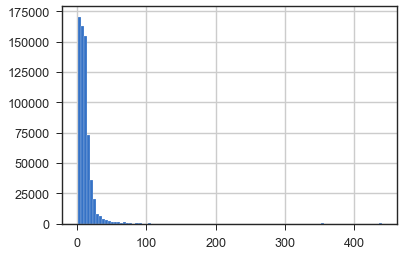

In [17]:
# plot the distribution
trees.block_count.hist(bins=100);

- I'll normalize the block count by taking the log value.

In [18]:
trees['log_block_count'] = trees.block_count.apply(lambda x: np.log(x))

# look at some descriptive stats
trees.log_block_count.describe()

count    652166.000000
mean          2.178280
std           0.778605
min           0.000000
25%           1.609438
50%           2.197225
75%           2.708050
max           6.086775
Name: log_block_count, dtype: float64

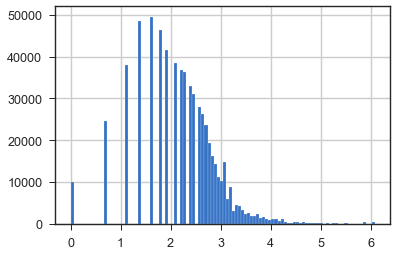

In [19]:
# plot the distribution
trees.log_block_count.hist(bins=100);

- This kind of occupies a grey area between continuous and categorical variable, but I'll be treating it as a continous variable. 
- I'll see if there is any obvious connection between the number of trees on the block and a trees health status.

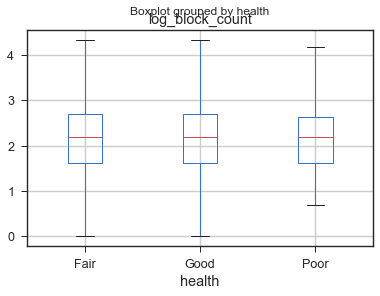

In [20]:
trees.boxplot('log_block_count', 'health', showfliers=False);

- The new feature doesn't look too promising, but I'll see if reining in extreme values affects this a little later on (after dropping volunteer entries).

#### Nearest tree neighbor feature
- Next, using GeoPandas, I'll engineer a feature to see if the distance to the nearest tree (a sort of proxy for tree density) has any discernible affect on tree health.

In [21]:
# create geodataframe with necessary columns
trees_gdf = gpd.GeoDataFrame(trees[['health', 'latitude', 'longitude']],
                             geometry=gpd.points_from_xy(trees.longitude, trees.latitude))

# look at the first five rows
trees_gdf.head()

,health,latitude,longitude,geometry
0,Fair,40.723092,-73.844215,POINT (-73.84422 40.72309)
1,Fair,40.794111,-73.818679,POINT (-73.81868 40.79411)
2,Good,40.717581,-73.936608,POINT (-73.93661 40.71758)
3,Good,40.713537,-73.934456,POINT (-73.93446 40.71354)
4,Good,40.666778,-73.975979,POINT (-73.97598 40.66678)


- Using scikit-learn's BallTree, along with some advanced mathematics (borrowed from a GIS wizard), I'll find the distance in meters to the closest tree within the dataframe.

In [22]:
%%time

# find closest tree and return a pandas series with a new distance column
closest_trees = nearest_neighbor(trees_gdf, 'neighbor_dist')

# look at the first five rows
closest_trees.head()

CPU times: user 4min 28s, sys: 191 ms, total: 4min 28s
Wall time: 4min 28s


0     5.507949
1    10.087328
2     3.098257
3    10.693152
4     5.258800
Name: neighbor_dist, dtype: float64

- After merging this onto the dataframe, I'll look at the mean, standard deviation, and distribution.

In [23]:
trees = trees.merge(closest_trees, left_index=True, right_index=True)
trees.head()

,block_id,tree_diameter,curb_loc,health,species,steward,guards,sidewalk,user_type,root_stone,...,council_dist,st_assembly,st_senate,nta,nta_name,latitude,longitude,block_count,log_block_count,neighbor_dist
0,348711,3,OnCurb,Fair,red maple,None,None,NoDamage,TreesCount Staff,No,...,29,28,16,QN17,Forest Hills,40.723092,-73.844215,15,2.708050,5.507949
1,315986,21,OnCurb,Fair,pin oak,None,None,Damage,TreesCount Staff,Yes,...,19,27,11,QN49,Whitestone,40.794111,-73.818679,21,3.044522,10.087328
2,218365,3,OnCurb,Good,honeylocust,1or2,None,Damage,Volunteer,No,...,34,50,18,BK90,East Williamsburg,40.717581,-73.936608,4,1.386294,3.098257
3,217969,10,OnCurb,Good,honeylocust,None,None,Damage,Volunteer,Yes,...,34,53,18,BK90,East Williamsburg,40.713537,-73.934456,4,1.386294,10.693152
4,223043,21,OnCurb,Good,American linden,None,None,Damage,Volunteer,Yes,...,39,44,21,BK37,Park Slope-Gowanus,40.666778,-73.975979,15,2.708050,5.258800


In [24]:
# descriptive stats
trees.neighbor_dist.describe()

count    652166.000000
mean          6.354636
std           4.197764
min           0.000000
25%           3.688507
50%           5.371356
75%           7.837000
max         275.599769
Name: neighbor_dist, dtype: float64

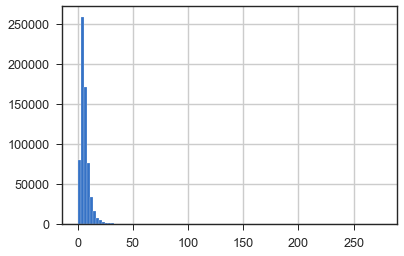

In [25]:
# distribution of data
trees.neighbor_dist.hist(bins=100);

- Definitely some outliers and positively skewed, seems to have a bit more normality to it. 
- I'll look at a boxplot to see if distance from the nearest tree has any discernible impact on health status.

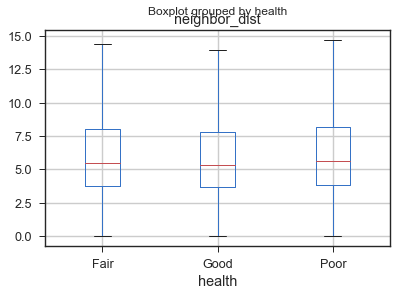

In [26]:
trees.boxplot('neighbor_dist', 'health', showfliers=False);

- Alas, the quartiles and medians are almost identical; there are no distinct differences here.
- Still, I'll keep this as a feature in my final model to see if it holds any predictive power there.


#### Look at volunteer data
- Now it's finally time to compare the data collected by volunteers and professional staff before dropping that of volunteers.

In [27]:
# a look at the raw numbers
trees.user_type.value_counts()

TreesCount Staff    282254
Volunteer           207776
NYC Parks Staff     162136
Name: user_type, dtype: int64

In [28]:
# by borough
trees.groupby('boroname').user_type.value_counts()

boroname       user_type       
Bronx          TreesCount Staff     45158
               NYC Parks Staff      22924
               Volunteer            12502
Brooklyn       Volunteer            74642
               TreesCount Staff     60594
               NYC Parks Staff      34507
Manhattan      Volunteer            41773
               TreesCount Staff     13715
               NYC Parks Staff       6939
Queens         TreesCount Staff    131917
               Volunteer            73150
               NYC Parks Staff      32903
Staten Island  NYC Parks Staff      64863
               TreesCount Staff     30870
               Volunteer             5709
Name: user_type, dtype: int64

- The proportion of volunteer data seems very inconsistent across boroughs.
    - Manhattan has a lot of volunteer entries, followed by Brooklyn.
    - Bronx and Staten Island are woefully underserved by volunteers.
    - Taking just the professional datapoints should hopefully keep the data more independent.
- Indeed, a comparison of maps of professional data points and volunteer data points shows that volunteers tended to not venture into the farther reaches of the city, which may have skewed their results.
    - *Note: Refer to my [mapmaking workbook](maps_creation.ipynb) for the source code of the maps below.*

![Comparison of Professional and Volunteer Data Maps](images/maps/pro_vol_comparison.png)

- I'll take a look at the differences in the proportions of health statuses among the different data collectors.

In [29]:
trees.groupby('user_type').health.value_counts(normalize=True)

user_type         health
NYC Parks Staff   Good      0.824314
                  Fair      0.131094
                  Poor      0.044592
TreesCount Staff  Good      0.814656
                  Fair      0.148069
                  Poor      0.037275
Volunteer         Good      0.795347
                  Fair      0.161020
                  Poor      0.043634
Name: health, dtype: float64

- Volunteers tend to rate fewer trees as 'Good' and more as 'Fair'. Perhaps a result of lack of training.
- Finally, while lacking any data to prove it, one may wonder if there may be a bias for volunteers tracking trees in their neighborhoods.
- It's time to drop volunteer entries and focus on the professional data.

In [30]:
# get indices of volunteer
volunteers = trees[trees.user_type == 'Volunteer'].index
 
# delete rows with these indices from dataFrame
trees.drop(volunteers, inplace=True)

# confirm
trees.shape

(444390, 30)

- I'll also go ahead and drop some more unnecessary columns now.
- The only things that may get dropped beyond this point will most likely be some of the regional location data (i.e. community board number, neighborhood, council district, etc.) as these are highly related to each other. I'll only need one or a couple. 

In [31]:
trees.columns

Index(['block_id', 'tree_diameter', 'curb_loc', 'health', 'species', 'steward',
       'guards', 'sidewalk', 'user_type', 'root_stone', 'root_grate',
       'root_other', 'trunk_wire', 'trunk_light', 'trunk_other',
       'branch_light', 'branch_shoe', 'branch_other', 'cb_num', 'boroname',
       'council_dist', 'st_assembly', 'st_senate', 'nta', 'nta_name',
       'latitude', 'longitude', 'block_count', 'log_block_count',
       'neighbor_dist'],
      dtype='object')

In [32]:
# drop unnecessary columns
drop_cols = ['block_id', 'user_type', 'nta_name', 'latitude', 'longitude', 'block_count']
trees.drop(columns=drop_cols, inplace=True)

# confirm new shape
trees.shape

(444390, 24)

- **Take a look at the target variable.**

In [33]:
trees.health.value_counts()

Good    363591
Fair     63048
Poor     17751
Name: health, dtype: int64

In [34]:
trees.health.value_counts(normalize=True)

Good    0.818180
Fair    0.141875
Poor    0.039945
Name: health, dtype: float64

- I only have three continuous variables (tree diameter, block count, and distance to closest tree). I'll go ahead and rein in the extreme values on those now.
- IMPORTANT NOTE: this step, along with feature engineering will have to also be performed on volunteer entries when I do end up running the model on those data points.

In [35]:
# before controlling outliers
trees[['tree_diameter', 'log_block_count', 'neighbor_dist']].describe()

,tree_diameter,log_block_count,neighbor_dist
count,444390.000000,444390.000000,444390.000000
mean,11.908191,2.200722,6.290772
std,8.831671,0.796849,4.280589
min,0.000000,0.000000,0.000000
25%,5.000000,1.609438,3.588350
50%,10.000000,2.197225,5.290265
75%,17.000000,2.708050,7.774294
max,425.000000,5.484797,275.599769


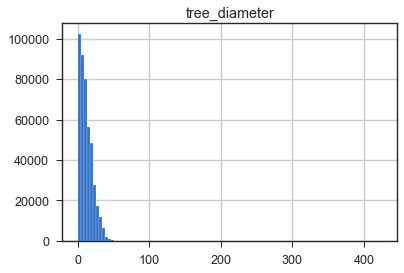

In [36]:
trees.hist('tree_diameter', bins=100);

In [37]:
rein_extremes(trees, ['tree_diameter', 'log_block_count', 'neighbor_dist'], 4)

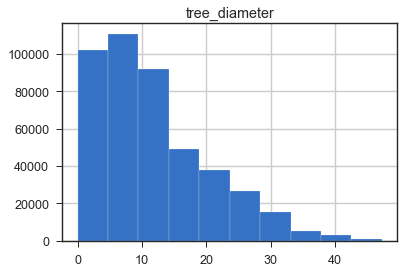

In [38]:
trees.hist('tree_diameter', bins=10);

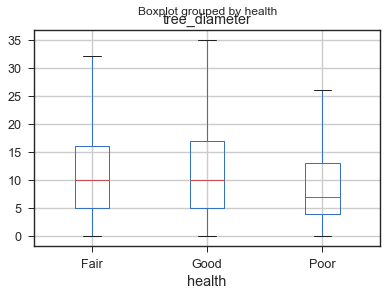

In [39]:
trees.boxplot('tree_diameter', 'health', showfliers=False);

- Tree diameter looks like a promising feature, as thinner trees tend to be in poor health as compared to thicker trees.
- Not much difference between trees in good and fair health, however.

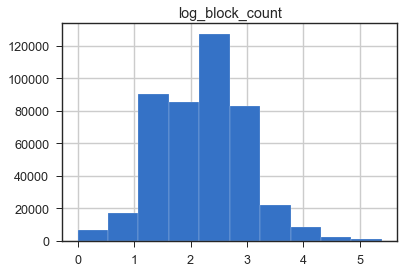

In [40]:
trees.hist('log_block_count', bins=10);

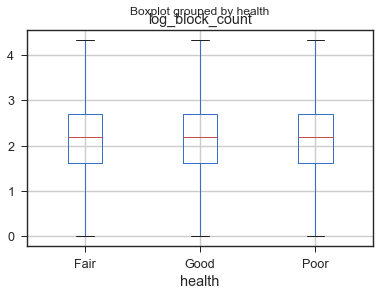

In [41]:
trees.boxplot('log_block_count', 'health', showfliers=False);

- A fairly normal distribution but no real relationship between it and health status.

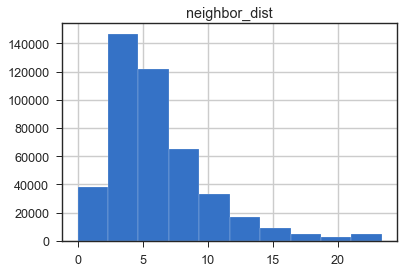

In [42]:
trees.hist('neighbor_dist', bins=10);

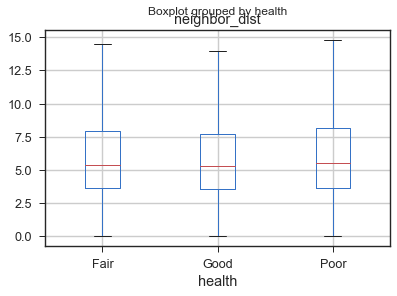

In [43]:
trees.boxplot('neighbor_dist', 'health', showfliers=False);

- Similar story here.
- Still, sometimes models create interactions between variables that prove powerful, so I'll keep these in until running some initial models.
- Now, I'm at the meat of my EDA, looking at all these categorical variables.

#### Boroughs
- Take a look at the health of trees across the boroughs.

In [44]:
trees.boroname.value_counts()

Queens           164820
Staten Island     95733
Brooklyn          95101
Bronx             68082
Manhattan         20654
Name: boroname, dtype: int64

In [45]:
trees.groupby('boroname').health.value_counts(normalize=True)

boroname       health
Bronx          Good      0.839914
               Fair      0.123513
               Poor      0.036574
Brooklyn       Good      0.808835
               Fair      0.151155
               Poor      0.040010
Manhattan      Good      0.778735
               Fair      0.165585
               Poor      0.055679
Queens         Good      0.820222
               Fair      0.141755
               Poor      0.038023
Staten Island  Good      0.817001
               Fair      0.140808
               Poor      0.042190
Name: health, dtype: float64

- Manhattan is rather different from the rest.

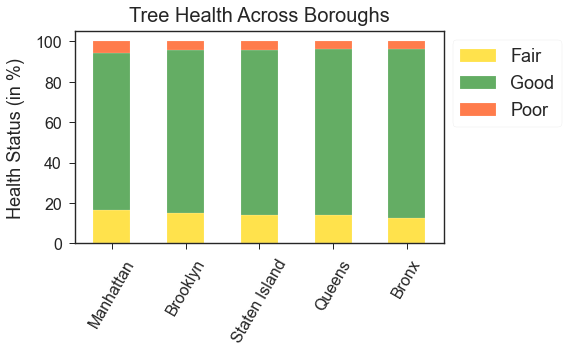

In [46]:
# prepare data for stacked bar, sort by percentage of trees in good health
boros = trees.groupby(['boroname']).health.value_counts(normalize=True).unstack().sort_values('Good')

# plot stacked bar graph
p1 = boros.plot(kind='bar', stacked=True, figsize=(8,5), color=['gold', 'forestgreen', 'orangered'], alpha=0.7)

# prettify the graph
p1.set_title('Tree Health Across Boroughs', fontsize=20, pad=10)
p1.set_xlabel('', fontsize=18, labelpad=10)
p1.set_xticklabels(p1.get_xticklabels(), fontsize=16, rotation=60)
p1.set_ylabel('Health Status (in %)', fontsize=18, labelpad=10)
p1.set_yticklabels([0, 20, 40, 60, 80, 100], fontsize=16)
p1.legend(['Fair','Good', 'Poor'], bbox_to_anchor=(1,1), fontsize=18)

# prepare to save and display
plt.tight_layout()
plt.savefig('images/charts/health_boro_barstack.png', bbox_inches='tight', transparent=True)
plt.show()

- Upon visualizing it though, it doesn't look all that different in the above graph.
- I'll do some statistical analyses to see if there's any significance to the differences.

In [47]:
# create a frequency table
df_boro_health = pd.crosstab(trees.health, trees.boroname)
df_boro_health

boroname,Bronx,Brooklyn,Manhattan,Queens,Staten Island
health,,,,,
Fair,8409,14375,3420,23364,13480
Good,57183,76921,16084,135189,78214
Poor,2490,3805,1150,6267,4039


In [48]:
# returns 𝜒2 value, p-value, degree of freedom and expected values
stat, p, dof, expected = stats.chi2_contingency(df_boro_health)

# p-value shows significance
p

3.530263683508544e-117

In [49]:
# create a table of standardized residuals; anything over +/-1.96 shows significance
table = sm.stats.Table(df_boro_health)
table.standardized_resids

boroname,Bronx,Brooklyn,Manhattan,Queens,Staten Island
health,,,,,
Fair,-14.922137,9.250982,10.000898,-0.177116,-1.068283
Good,15.977694,-8.427983,-15.051476,2.710004,-1.067351
Poor,-4.881134,0.116258,11.825406,-5.021920,4.005638


In [50]:
# percentage of significant values
abs_table = table.standardized_resids.apply(lambda x: abs(x))
print(f'{round((abs_table[abs_table > 1.96].count().sum() / abs_table.count().sum()) * 100, 2)}%')

73.33%


- Most differences appear to be significant, though not all.

#### Community Boards

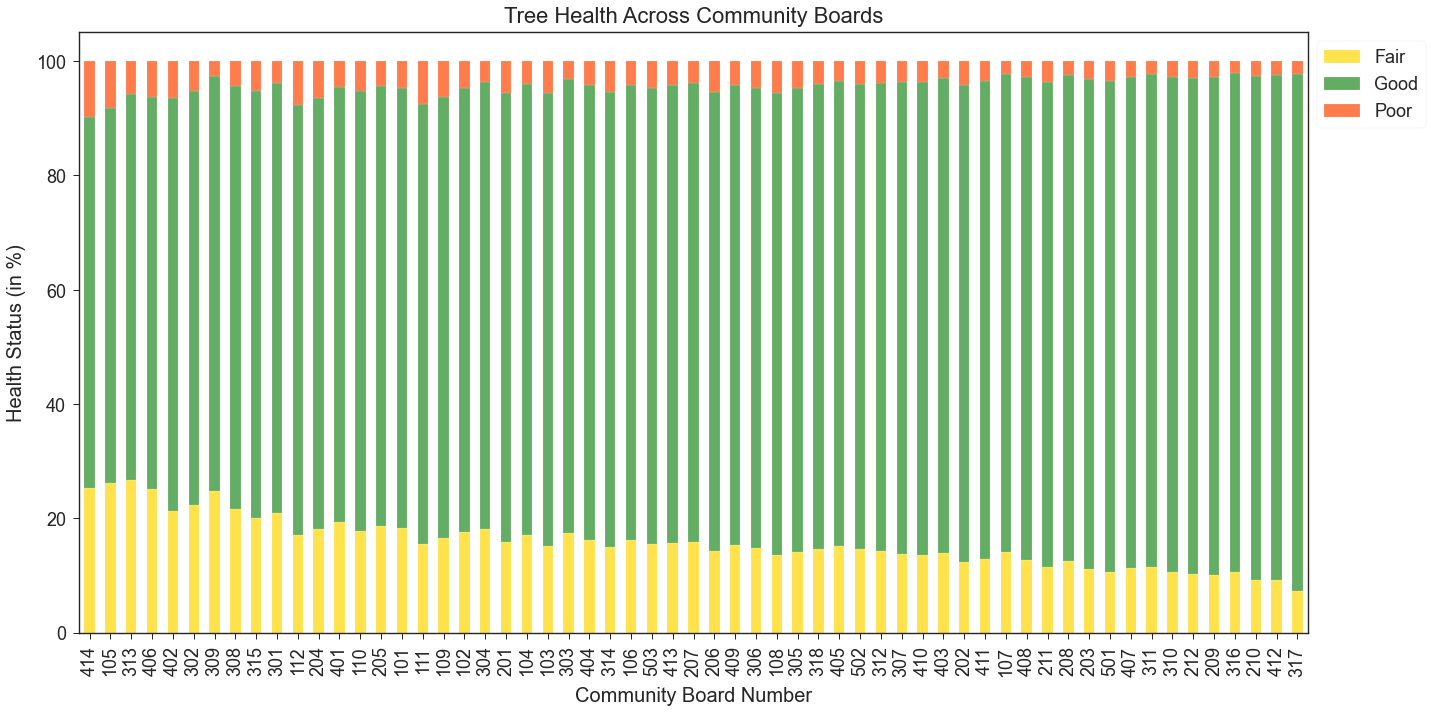

In [51]:
# prepare data for stacked bar, sort by percentage of trees in good health
community_boards = trees.groupby(['cb_num']).health.value_counts(normalize=True).unstack().sort_values('Good')

# plot stacked bar graph
p2 = community_boards.plot(kind='bar', stacked=True, figsize=(20,10),
                   color=['gold', 'forestgreen', 'orangered'], alpha=0.7)

# prettify the graph
p2.set_title('Tree Health Across Community Boards', fontsize=22, pad=10)
p2.set_xlabel('Community Board Number', fontsize=20, labelpad=10)
p2.set_xticklabels(p2.get_xticklabels(), fontsize=18)
p2.set_ylabel('Health Status (in %)', fontsize=20, labelpad=10)
p2.set_yticklabels([0, 20, 40, 60, 80, 100], fontsize=18)
p2.legend(['Fair','Good', 'Poor'], bbox_to_anchor=(1,1), fontsize=18)

# prepare to save and display
plt.tight_layout()
plt.savefig('images/charts/health_cb_barstack.png', bbox_inches='tight', transparent=True)
plt.show()

- The differences here seem stronger, at least comparing the left portion of the graph to the right.
- Time for more statistical analyses.

In [52]:
# create a frequency table
df_cb_health = pd.crosstab(trees.health, trees.cb_num)
df_cb_health

cb_num,101,102,103,104,105,106,107,108,109,110,...,408,409,410,411,412,413,414,501,502,503
health,,,,,,,,,,,,,,,,,,,,,
Fair,344,316,232,154,151,198,253,282,296,375,...,1940,1019,1780,2715,2082,4997,2438,2518,3291,7671
Good,1446,1395,1212,710,377,977,1495,1676,1375,1619,...,12952,5343,10898,17499,19767,25522,6231,20231,18306,39677
Poor,89,86,85,36,47,51,40,115,113,111,...,438,278,485,719,541,1314,933,809,910,2320


In [53]:
# returns 𝜒2 value, p-value, degree of freedom and expected values
stat, p, dof, expected = stats.chi2_contingency(df_cb_health)

# test-statistic far greater than critical value
prob = 0.95
critical = stats.chi2.ppf(prob, dof)
critical, stat

(142.13816003902645, 7345.570039622511)

In [54]:
# create a table of standardized residuals; anything over +/-1.96 shows significance
table2 = sm.stats.Table(df_cb_health)
table2.standardized_resids

cb_num,101,102,103,104,105,106,107,108,109,110,...,408,409,410,411,412,413,414,501,502,503
health,,,,,,,,,,,,,,,,,,,,,
Fair,5.129318,4.135827,1.106630,2.516209,8.302588,1.972131,-0.045719,-0.763919,2.916401,4.780778,...,-5.534750,2.726784,-2.219009,-5.172068,-21.514019,8.013637,31.807539,-15.816677,1.917722,8.518952
Good,-5.476062,-4.612954,-2.590196,-2.280614,-10.111078,-1.934466,1.971846,-1.146535,-5.205602,-5.849639,...,8.722672,-2.876107,2.943221,6.829744,25.745851,-7.889693,-43.472485,16.600254,-1.929381,-11.854639
Poor,1.646141,1.716374,3.129772,0.008489,5.121022,0.296153,-3.802197,3.619290,5.056362,3.002939,...,-7.318128,0.806150,-1.843072,-4.236120,-12.374838,1.260728,28.947729,-4.513437,0.383085,8.169549


In [55]:
# percentage of significant values
abs_table2 = table2.standardized_resids.apply(lambda x: abs(x))
print(f'{round((abs_table2[abs_table2 > 1.96].count().sum() / abs_table2.count().sum()) * 100, 2)}%')

75.71%


- A similar level of significance in health results across the community boards.

#### Neighborhoods

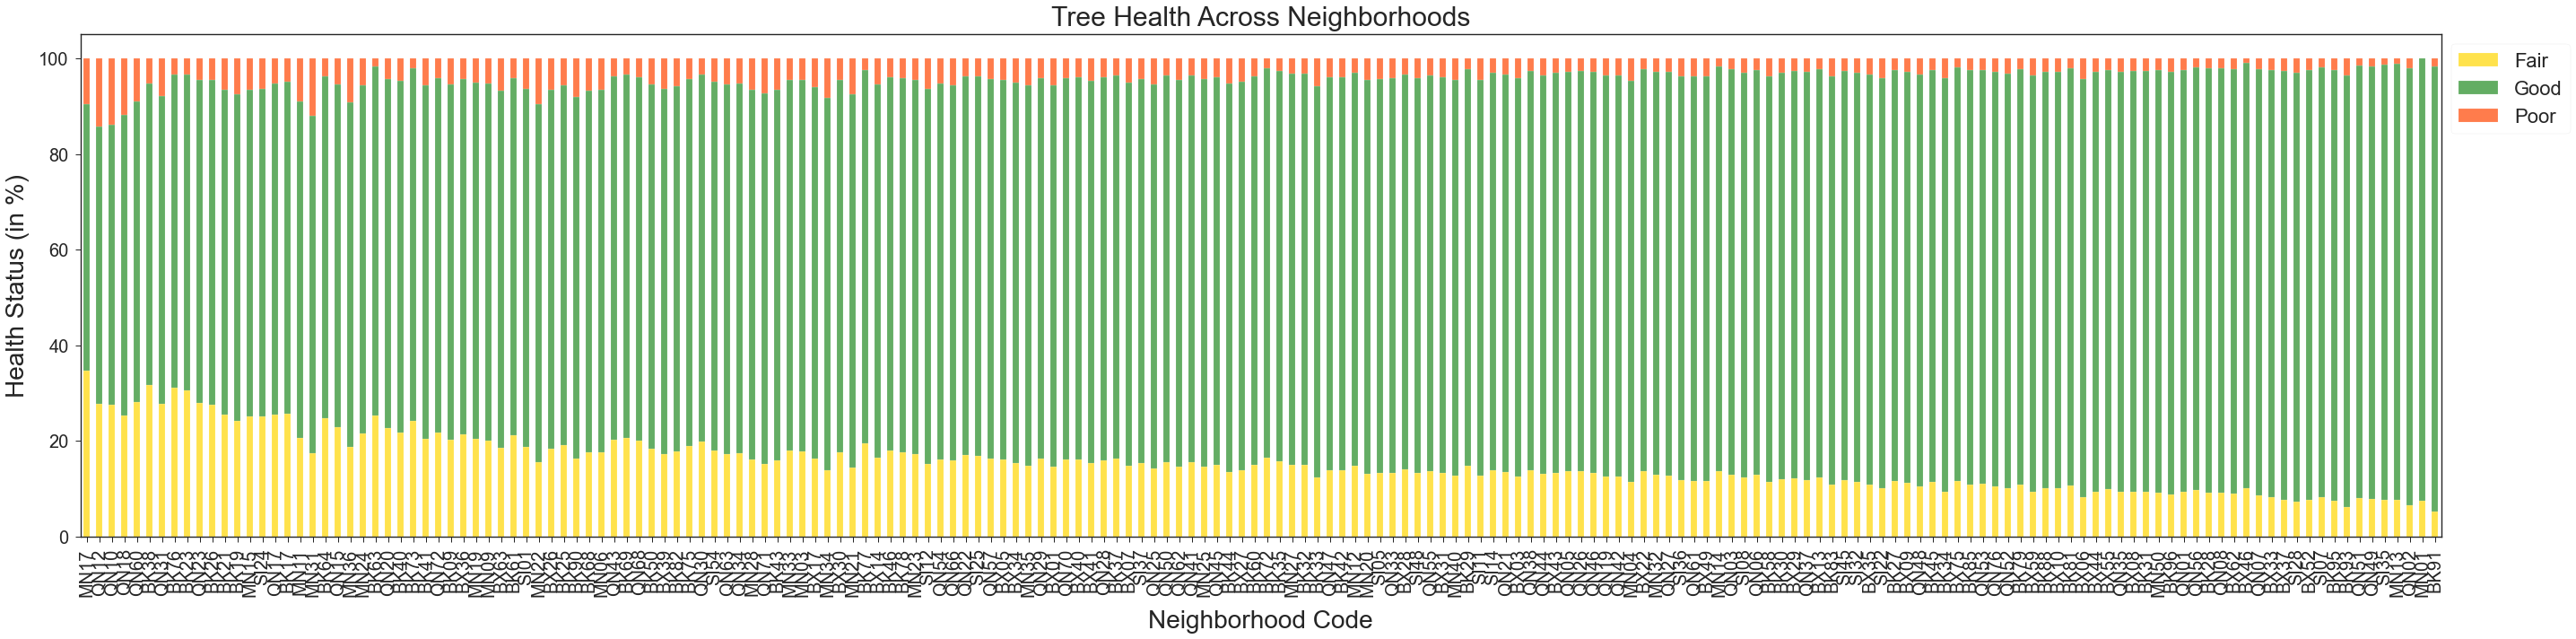

In [56]:
# prepare data for stacked bar, sort by percentage of trees in good health
neighborhoods = trees.groupby(['nta']).health.value_counts(normalize=True).unstack().sort_values('Good')

# plot stacked bar graph
p3 = neighborhoods.plot(kind='bar', stacked=True, figsize=(40,10),
                        color=['gold', 'forestgreen', 'orangered'], alpha=0.7)

# prettify the graph
p3.set_title('Tree Health Across Neighborhoods', fontsize=30, pad=10)
p3.set_xlabel('Neighborhood Code', fontsize=28, labelpad=15)
p3.set_xticklabels(p3.get_xticklabels(), fontsize=20)
p3.set_ylabel('Health Status (in %)', fontsize=28, labelpad=10)
p3.set_yticklabels([0, 20, 40, 60, 80, 100], fontsize=20)
p3.legend(['Fair','Good', 'Poor'], bbox_to_anchor=(1,1), fontsize=22)

# prepare to save and display
plt.tight_layout()
plt.savefig('images/charts/health_nbhd_barstack.png', bbox_inches='tight', transparent=True)
plt.show()

- There seems to be a similar difference between the neighborhoods, though these may be too correlated to community board, since each community board is composed of one or a few neighborhoods.
- Perform the same statistical analyses.

In [57]:
# create a frequency table
df_nta_health = pd.crosstab(trees.health, trees.nta)
df_nta_health

nta,BK09,BK17,BK19,BK21,BK23,BK25,BK26,BK27,BK28,BK29,...,SI24,SI25,SI28,SI32,SI35,SI36,SI37,SI45,SI48,SI54
health,,,,,,,,,,,,,,,,,,,,,
Fair,30,1132,182,314,136,675,215,151,187,296,...,959,668,214,1008,238,560,521,519,880,1782
Good,110,3082,514,839,295,2672,529,1116,1809,1655,...,2618,3134,2681,7563,2861,4035,2737,3764,5521,7685
Poor,8,215,57,81,15,197,35,32,41,45,...,241,150,92,271,40,175,148,119,275,482


In [58]:
# returns 𝜒2 value, p-value, degree of freedom and expected values
stat, p, dof, expected = stats.chi2_contingency(df_nta_health)

# test-statistic far greater than critical value
prob = 0.95
critical = stats.chi2.ppf(prob, dof)
critical, stat

(420.09408303637986, 12810.553650717877)

In [59]:
# create a table of standardized residuals; anything over +/-1.96 shows significance
table3 = sm.stats.Table(df_nta_health)
table3.standardized_resids

nta,BK09,BK17,BK19,BK21,BK23,BK25,BK26,BK27,BK28,BK29,...,SI24,SI25,SI28,SI32,SI35,SI36,SI37,SI45,SI48,SI54
health,,,,,,,,,,,,,,,,,,,,,
Fair,2.121165,21.797632,7.857331,11.350140,9.874106,8.323038,10.737758,-2.651511,-6.491918,0.824057,...,19.440027,4.914049,-11.037866,-7.587663,-10.644162,-4.870721,1.862093,-4.581456,-2.373582,10.766321
Good,-2.363995,-21.210308,-9.653901,-12.611392,-8.586783,-9.953336,-10.074908,3.831576,8.197327,1.274632,...,-21.315473,-4.119667,11.285759,9.153572,13.594823,4.992886,-2.217250,6.376933,1.881180,-11.963350
Poor,0.876589,2.936571,5.013913,4.615492,-0.681190,4.773887,0.710913,-2.822096,-4.577958,-3.978687,...,7.344349,-0.641763,-2.561007,-4.508978,-7.810264,-1.155269,1.049172,-4.396590,0.524073,4.379370


In [60]:
# percentage of significant values
abs_table3 = table3.standardized_resids.apply(lambda x: abs(x))
print(f'{round((abs_table3[abs_table3 > 1.96].count().sum() / abs_table3.count().sum()) * 100, 2)}%')

68.97%


- The percentage of significant values is lower than that of community boards.
    - This, plus the fact that residents wanting to make changes to street trees must go through their community board, can be used as an argument for choosing community boards as a feature instead.
    
- Since there are so many features that serve as proxies for a tree's location, I'll compare their rates of values of significant difference all at once.

In [61]:
# list of features that contain information about a tree's location in the city 
testers = ['boroname', 'cb_num', 'council_dist', 'nta', 'st_assembly', 'st_senate']
for tester in testers:
    
    # create a frequency table
    df_ = pd.crosstab(trees.health, trees[tester])
    
    # create a table of standardized residuals; anything over +/-1.96 shows significance
    table_ = sm.stats.Table(df_)
    
    # percentage of significant values
    abs_table_ = table_.standardized_resids.apply(lambda x: abs(x))
    print(f'{tester}: {round((abs_table_[abs_table_ > 1.96].count().sum() / abs_table_.count().sum()) * 100, 2)}%')

boroname: 73.33%
cb_num: 75.71%
council_dist: 77.78%
nta: 68.97%
st_assembly: 77.95%
st_senate: 80.77%


- Interesting: governmental districts tend to have the highest rates of significantly different values.
- Still, when thinking about the data, community board seems like the best choice of location feature, alongside borough.
    - New Yorkers very much identify with their borough, and community board is more on the neighborhood level, while holding decently more significantly different values than nta.
- For future reference, I'll look at state senate districts, which hold the highest rate of significantly different values.

#### State Senate Districts

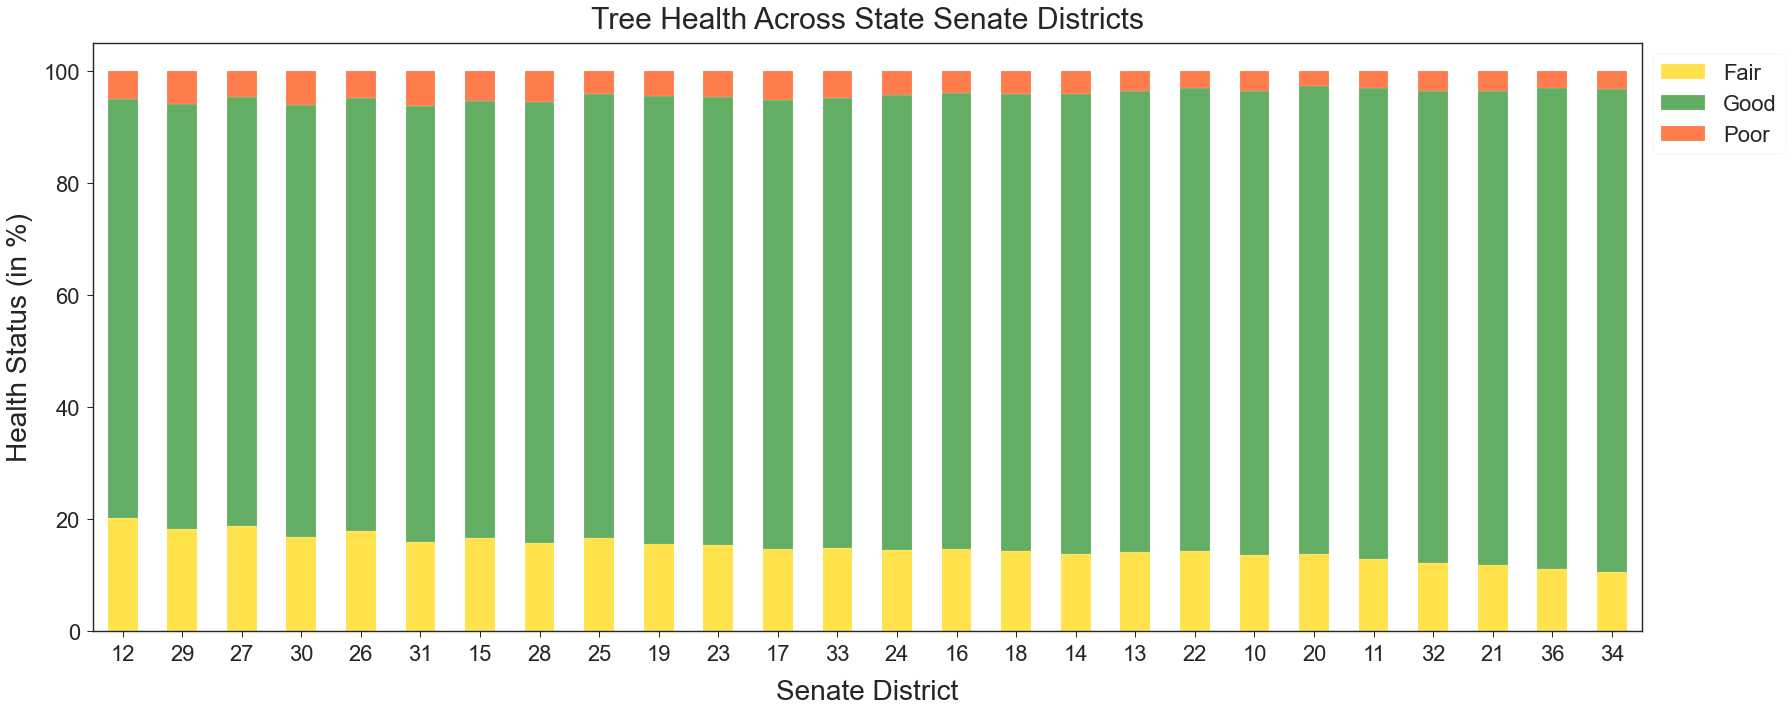

In [62]:
# prepare data for stacked bar, sort by percentage of trees in good health
st_snt = trees.groupby(['st_senate']).health.value_counts(normalize=True).unstack().sort_values('Good')

# plot stacked bar graph
p3b = st_snt.plot(kind='bar', stacked=True, figsize=(25,10), color=['gold', 'forestgreen', 'orangered'], alpha=0.7)

# prettify the graph
p3b.set_title('Tree Health Across State Senate Districts', fontsize=30, pad=15)
p3b.set_xlabel('Senate District', fontsize=28, labelpad=15)
p3b.set_xticklabels(p3b.get_xticklabels(), rotation='horizontal', fontsize=22)
p3b.set_ylabel('Health Status (in %)', fontsize=28, labelpad=10)
p3b.set_yticklabels([0, 20, 40, 60, 80, 100], fontsize=22)
p3b.legend(['Fair','Good', 'Poor'], bbox_to_anchor=(1,1), fontsize=22)

# prepare to save and display
plt.tight_layout()
plt.savefig('images/charts/health_senate_barstack.png', bbox_inches='tight', transparent=True)
plt.show()

In [63]:
# create a frequency table
df_snt = pd.crosstab(trees.health, trees.st_senate)
df_snt

st_senate,10,11,12,13,14,15,16,17,18,19,...,26,27,28,29,30,31,32,33,34,36
health,,,,,,,,,,,,,,,,,,,,,
Fair,3675,6815,1215,997,4219,4142,2299,1994,1122,3809,...,888,590,482,1358,831,745,1620,1507,2730,1322
Good,22605,44739,4506,5870,25245,19473,12746,10903,6379,19724,...,3857,2426,2433,5673,3821,3657,11258,8208,22610,10218
Poor,957,1610,301,246,1220,1323,610,693,320,1098,...,235,142,170,438,299,289,469,483,806,357


In [64]:
# create a table of standardized residuals; anything over +/-1.96 shows significance
table4 = sm.stats.Table(df_snt)
table4.standardized_resids

st_senate,10,11,12,13,14,15,16,17,18,19,...,26,27,28,29,30,31,32,33,34,36
health,,,,,,,,,,,,,,,,,,,,,
Fair,-3.392222,-9.639641,13.409767,-0.416550,-2.277409,11.281192,1.817599,1.645814,0.405191,5.908649,...,7.411160,7.265615,2.294573,9.977500,5.266404,3.342764,-6.891827,1.727133,-17.894877,-9.745348
Good,5.192473,14.875920,-14.164834,1.558396,2.147120,-15.729262,-1.320817,-4.880626,-0.591148,-7.285157,...,-8.037462,-7.306987,-4.266658,-13.251488,-8.515463,-6.891319,7.696308,-3.527251,20.128851,11.664743
Poor,-4.182700,-12.123317,4.005303,-2.327148,-0.171052,10.879156,-0.637121,6.680195,0.442341,3.820663,...,2.625243,1.445860,4.315015,8.321924,7.388149,7.616792,-2.878653,3.869758,-7.760328,-5.610385


In [65]:
# percentage of significant values
abs_table4 = table4.standardized_resids.apply(lambda x: abs(x))
print(f'{round((abs_table4[abs_table4 > 1.96].count().sum() / abs_table4.count().sum()) * 100, 2)}%')

80.77%


- One could easily make the argument that this is the location feature to use, but I'll move forward with community board and borough for the reasons outlined above.

#### Tree species

In [66]:
# species total
print(f'Number of unique species: {len(trees.species.unique())}')

# total trees in current dataset
print(f'Number of total trees: {len(trees)}')

# somewhat arbitrarily assign a value at which I'll lump rarer trees together
print(f'Cutoff for trees of significant quantity (0.1% of total trees): {np.ceil(len(trees)/1000)}')

Number of unique species: 132
Number of total trees: 444390
Cutoff for trees of significant quantity (0.1% of total trees): 445.0


In [67]:
# create a column with the total count of that row's tree species
species_counts = trees['species'].value_counts().rename('species_counts')

# merge onto dataframe
trees = trees.merge(species_counts.to_frame(),
                                left_on='species',
                                right_index=True)

# reassign tree species with fewer than 445 datapoints to 'Other'
trees['species'] = np.where(trees.species_counts < 445, 'Other', trees.species)

# take a look
trees.species.value_counts().head(20)

London planetree     60350
Callery pear         42487
honeylocust          38349
pin oak              35985
Norway maple         25253
cherry               22772
Japanese zelkova     18928
littleleaf linden    18469
red maple            13906
ginkgo               11355
green ash            10572
Sophora              10440
silver maple         10081
Other                 9918
American linden       8399
sweetgum              8380
purple-leaf plum      5281
maple                 5211
American elm          5192
northern red oak      5153
Name: species, dtype: int64

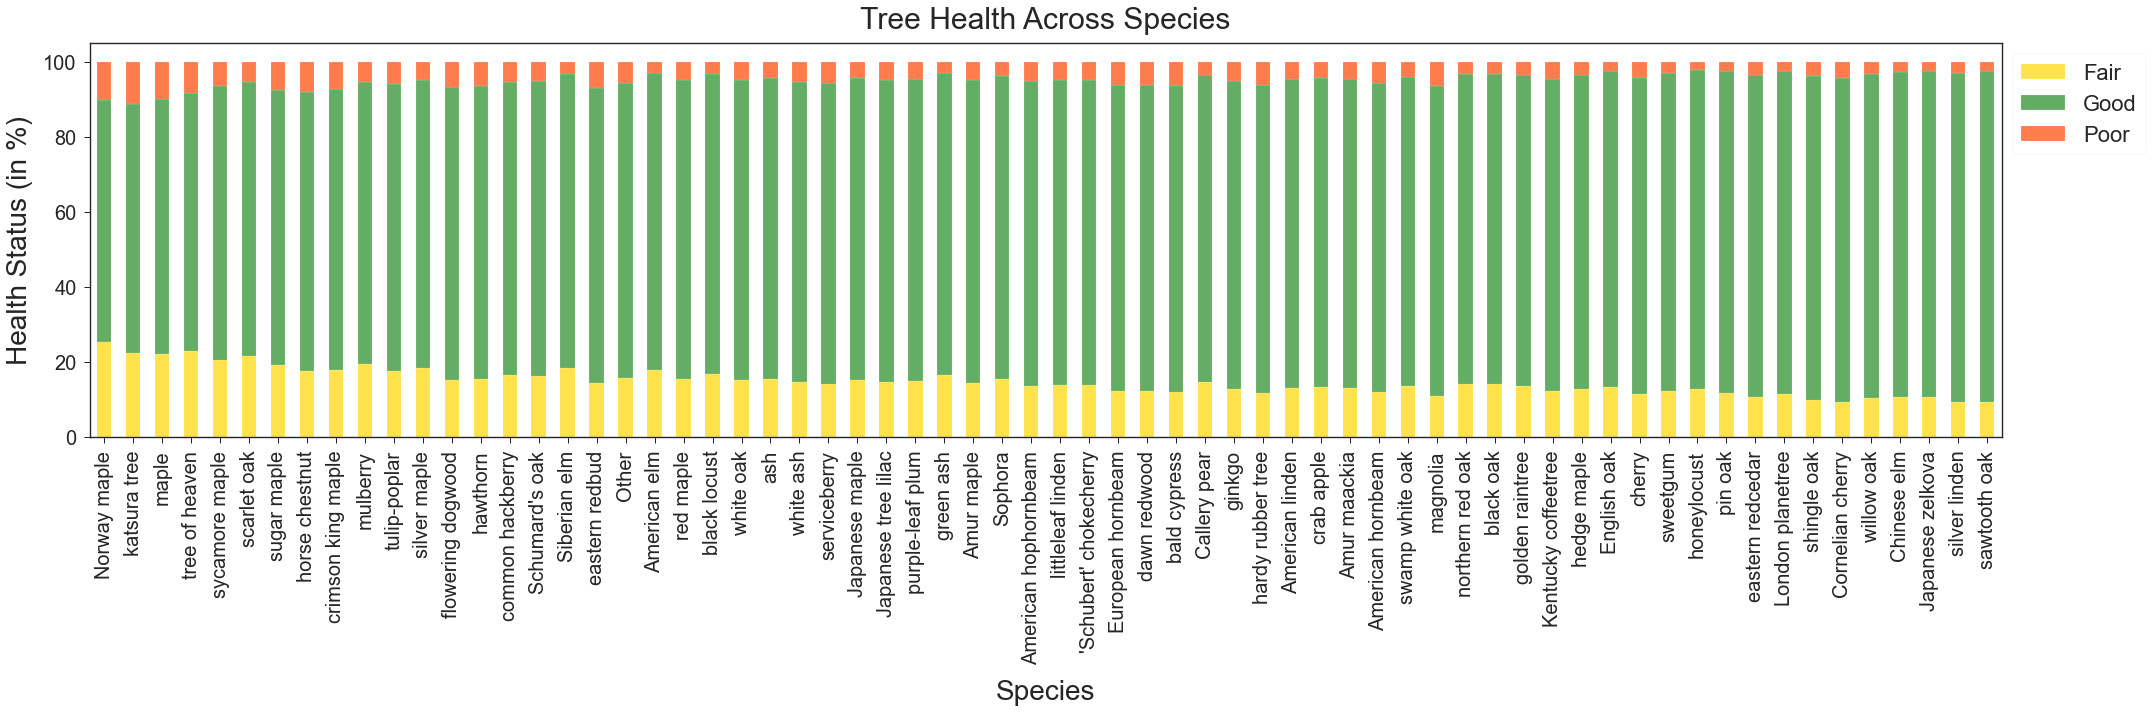

In [68]:
# prepare data for stacked bar, sort by percentage of trees in good health
spc = trees.groupby(['species']).health.value_counts(normalize=True).unstack().sort_values('Good')

# plot stacked bar graph
p4 = spc.plot(kind='bar', stacked=True, figsize=(30,10), color=['gold', 'forestgreen', 'orangered'], alpha=0.7)

# prettify the graph
p4.set_title('Tree Health Across Species', fontsize=30, pad=15)
p4.set_xlabel('Species', fontsize=28, labelpad=15)
p4.set_xticklabels(p4.get_xticklabels(), fontsize=20)
p4.set_ylabel('Health Status (in %)', fontsize=28, labelpad=10)
p4.set_yticklabels([0, 20, 40, 60, 80, 100], fontsize=20)
p4.legend(['Fair','Good', 'Poor'], bbox_to_anchor=(1,1), fontsize=22)

# prepare to save and display
plt.tight_layout()
plt.savefig('images/charts/health_species_barstack.png', bbox_inches='tight', transparent=True)
plt.show()

- Some definite differences between the left and right portions of the chart.
- Time for more statistical analyses.

In [69]:
# create a frequency table
df_spc_health = pd.crosstab(trees.health, trees.species)
df_spc_health

species,'Schubert' chokecherry,American elm,American hophornbeam,American hornbeam,American linden,Amur maackia,Amur maple,Callery pear,Chinese elm,Cornelian cherry,...,silver maple,sugar maple,swamp white oak,sweetgum,sycamore maple,tree of heaven,tulip-poplar,white ash,white oak,willow oak
health,,,,,,,,,,,,,,,,,,,,,
Fair,442,926,93,140,1099,225,237,6216,304,65,...,1843,350,568,1017,405,106,129,130,175,210
Good,2606,4110,559,954,6913,1412,1342,34820,2444,608,...,7771,1345,3473,7125,1433,321,560,712,916,1761
Poor,151,156,35,63,387,77,79,1451,77,30,...,467,134,167,238,126,38,43,46,54,65


In [70]:
# returns 𝜒2 value, p-value, degree of freedom and expected values
stat, p, dof, expected = stats.chi2_contingency(df_spc_health)

# test-statistic far greater than critical value
prob = 0.95
critical = stats.chi2.ppf(prob, dof)
critical, stat

(157.60992312288903, 10713.620636908676)

In [71]:
# create a table of standardized residuals; anything over +/-1.96 shows significance
table4 = sm.stats.Table(df_spc_health)
table4.standardized_resids

species,'Schubert' chokecherry,American elm,American hophornbeam,American hornbeam,American linden,Amur maackia,Amur maple,Callery pear,Chinese elm,Cornelian cherry,...,silver maple,sugar maple,swamp white oak,sweetgum,sycamore maple,tree of heaven,tulip-poplar,white ash,white oak,willow oak
health,,,,,,,,,,,,,,,,,,,,,
Fair,-0.603106,7.576995,-0.488967,-2.037439,-2.923916,-1.260565,0.124858,2.750728,-5.236162,-3.757917,...,11.917738,6.077938,-1.287867,-5.433738,8.189565,5.322743,2.666022,0.386499,1.064549,-5.020267
Good,-0.522527,-4.994458,-0.305859,0.562176,1.174069,0.604845,-0.927706,0.766975,6.490975,3.211830,...,-12.461487,-9.200599,1.208732,7.681683,-10.196686,-7.152113,-3.731584,-1.266663,-1.597022,5.481938
Poor,2.103740,-3.663597,1.473631,2.523008,2.897351,1.054760,1.604699,-6.411759,-3.454697,0.369866,...,3.308921,7.291597,-0.085981,-5.447825,5.491013,4.602577,2.599321,1.806109,1.248642,-1.852017


In [72]:
# percentage of significant values
abs_table4 = table4.standardized_resids.apply(lambda x: abs(x))
print(f'{round((abs_table4[abs_table4 > 1.96].count().sum() / abs_table4.count().sum()) * 100, 2)}%')

62.12%


- Pretty low as compared to the location features, but seems important enough to include.

In [73]:
# drop no longer necessary counts column
trees.drop(columns='species_counts', axis=1, inplace=True)

In [74]:
# uncomment to save
trees.to_csv('data/nyc_trees_2015_pre_dummies.csv')

### Dummy columns
- I have a lot of categorical variables that I need to make dummies for.
- As mentioned before, I'll move forward with community board and borough, though one could swap these out for any combination of other area features, though it's important to think about correlation and multicollinearity.

In [75]:
# I need to merge on 'tree_id', so I won't set that as the index column yet
trees = pd.read_csv('data/nyc_trees_2015_pre_dummies.csv', index_col=0)

In [76]:
trees.columns

Index(['tree_diameter', 'curb_loc', 'health', 'species', 'steward', 'guards',
       'sidewalk', 'root_stone', 'root_grate', 'root_other', 'trunk_wire',
       'trunk_light', 'trunk_other', 'branch_light', 'branch_shoe',
       'branch_other', 'cb_num', 'boroname', 'council_dist', 'st_assembly',
       'st_senate', 'nta', 'log_block_count', 'neighbor_dist'],
      dtype='object')

- Convert binary object columns to dummy 0 and 1.

In [77]:
trees.curb_loc.unique()

array(['OnCurb', 'OffsetFromCurb'], dtype=object)

In [78]:
trees.sidewalk.unique()

array(['NoDamage', 'Damage'], dtype=object)

In [79]:
# rename columns that we have to manually dummy, so the new 0 and 1 values make sense
trees.rename(columns={'curb_loc': 'on_curb', 'sidewalk': 'sidewalk_damage'}, inplace=True)

# trees on curb = 1; trees offset from curb = 0
trees.on_curb = np.where(trees.on_curb == 'OnCurb', 1, 0)
# damage to sidewalk near tree = 1; no sidewalk damage = 0
trees.sidewalk_damage = np.where(trees.sidewalk_damage == 'Damage', 1, 0)

- Reassign yes-no columns to 1s and 0s.

In [80]:
trees.branch_other.unique()

array(['No', 'Yes'], dtype=object)

In [81]:
# create list of columns to dummy
yes_no_cols = ['root_stone', 'root_grate', 'root_other', 'trunk_wire', 'trunk_light', 'trunk_other',
               'branch_light', 'branch_shoe', 'branch_other']

# call custom function
yes_to_one(trees, yes_no_cols)
# check to make sure it worked
trees.branch_other.unique()

array([0, 1])

In [82]:
yes_no_cols.extend(['on_curb', 'sidewalk_damage'])

- Visualize differences in above columns.

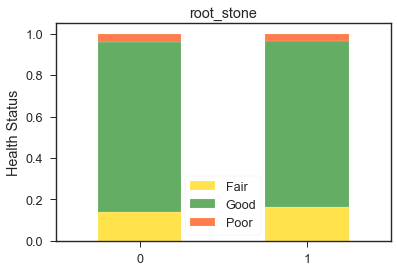

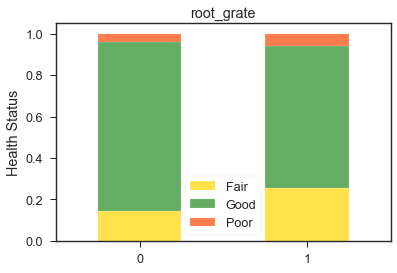

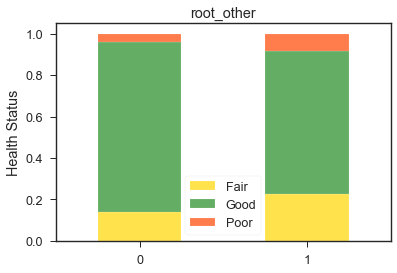

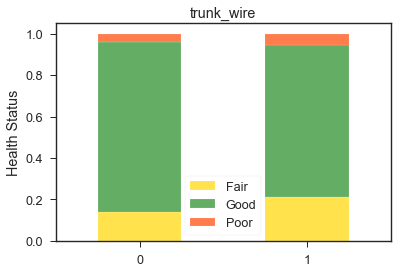

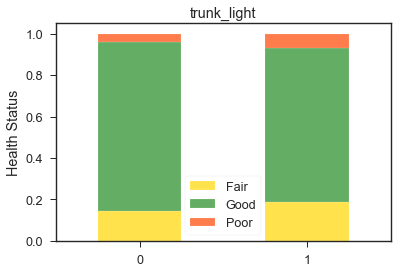

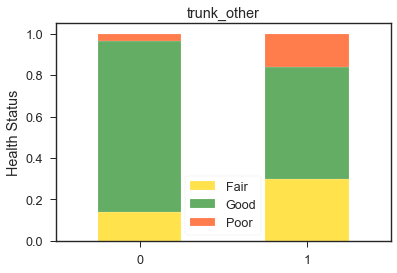

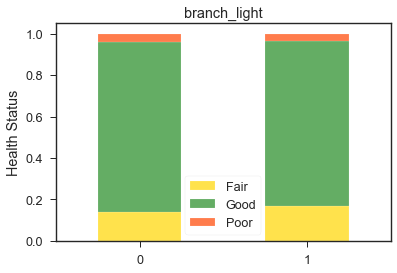

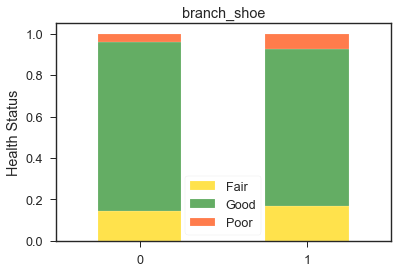

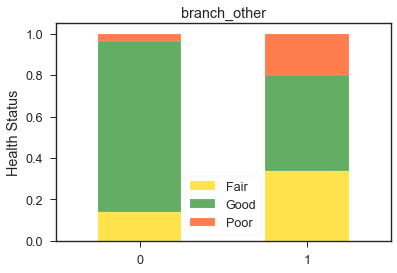

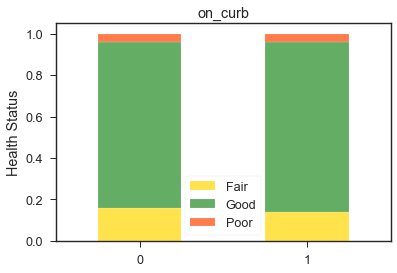

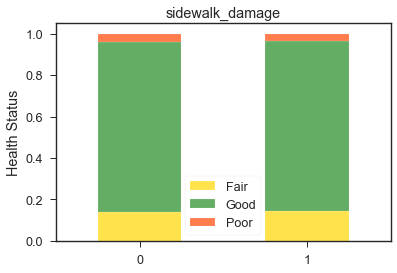

In [83]:
# for loop to visualize the health breakdown of these binary variables
for col in yes_no_cols:
    
    # groupby column and look at health
    grouped = trees.groupby(col).health.value_counts(normalize=True).unstack()
    
    # stacked bar graph
    ax = grouped.plot(kind='bar', stacked=True, color=['gold', 'forestgreen', 'orangered'], alpha=0.7)
    
    # prettify a bit
    ax.set_title(col)
    ax.set_xticklabels([0,1], rotation=0)
    ax.set_xlabel('')
    ax.set_ylabel('Health Status')
    ax.legend(['Fair','Good', 'Poor'])

- Lots of significant looking variables here.
- Some that don't quite pass the "visualization test" are: root_stone, branch_light, on_curb, and sidewalk_damage.

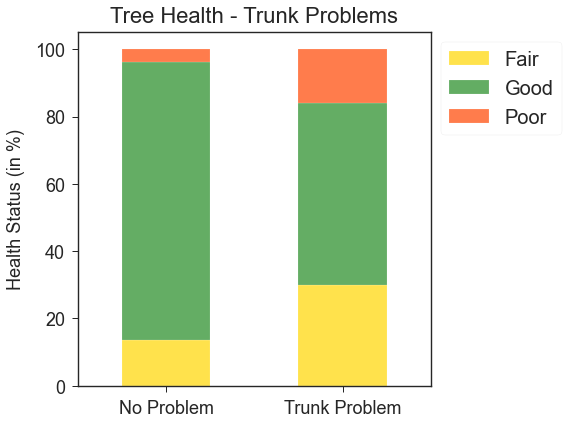

In [84]:
# prepare data for stacked bar, sort by percentage of trees in good health
trunk_o = trees.groupby(['trunk_other']).health.value_counts(normalize=True).unstack().sort_values('Good', ascending=False)

# plot stacked bar graph
p5 = trunk_o.plot(kind='bar', stacked=True, figsize=(8,6), 
                  color=['gold', 'forestgreen', 'orangered'], alpha=0.7, fontsize=14)

# prettify the graph
p5.set_title('Tree Health - Trunk Problems', fontsize=22, pad=10)
p5.set_xlabel('')
p5.set_xticklabels(['No Problem', 'Trunk Problem'], rotation='horizontal', fontsize=18)
p5.set_ylabel('Health Status (in %)', fontsize=18, labelpad=10)
p5.set_yticklabels([0, 20, 40, 60, 80, 100], fontsize=18)
p5.legend(['Fair','Good', 'Poor'], fontsize=20, bbox_to_anchor=(1,1))

# prepare to save and display
plt.tight_layout()
plt.savefig('images/charts/health_trunk_barstack.png', bbox_inches='tight', transparent=True)
plt.show()

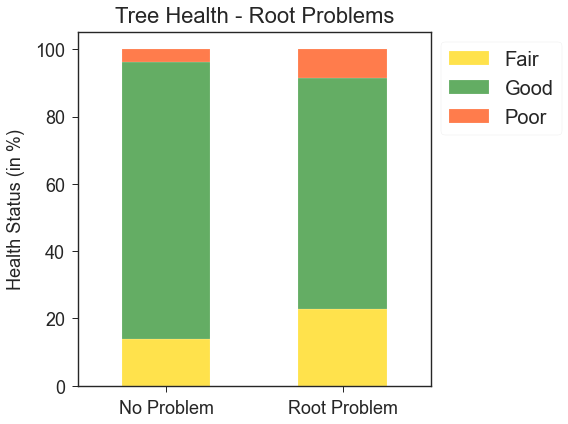

In [85]:
# prepare data for stacked bar, sort by percentage of trees in good health
root_o = trees.groupby(['root_other']).health.value_counts(normalize=True).unstack().sort_values('Good', ascending=False)

# plot stacked bar graph
p6 = root_o.plot(kind='bar', stacked=True, figsize=(8,6), 
                  color=['gold', 'forestgreen', 'orangered'], alpha=0.7, fontsize=14)

# prettify the graph
p6.set_title('Tree Health - Root Problems', fontsize=22, pad=10)
p6.set_xlabel('')
p6.set_xticklabels(['No Problem', 'Root Problem'], rotation='horizontal', fontsize=18)
p6.set_ylabel('Health Status (in %)', fontsize=18, labelpad=10)
p6.set_yticklabels([0, 20, 40, 60, 80, 100], fontsize=18)
p6.legend(['Fair','Good', 'Poor'], fontsize=20, bbox_to_anchor=(1,1))

# prepare to save and display
plt.tight_layout()
plt.savefig('images/charts/health_root_barstack.png', bbox_inches='tight', transparent=True)
plt.show()

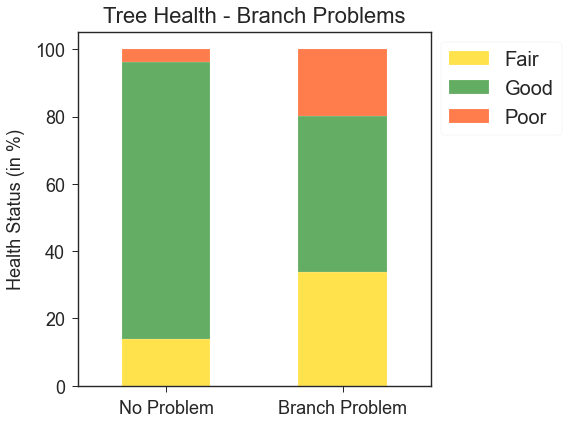

In [86]:
# prepare data for stacked bar, sort by percentage of trees in good health
branch_o = trees.groupby(['branch_other']).health.value_counts(normalize=True).unstack().sort_values('Good', ascending=False)

# plot stacked bar graph
p7 = branch_o.plot(kind='bar', stacked=True, figsize=(8,6),
                   color=['gold', 'forestgreen', 'orangered'], alpha=0.7, fontsize=14)

# prettify the graph
p7.set_title('Tree Health - Branch Problems', fontsize=22, pad=10)
p7.set_xlabel('')
p7.set_xticklabels(['No Problem', 'Branch Problem'], rotation='horizontal', fontsize=18)
p7.set_ylabel('Health Status (in %)', fontsize=18, labelpad=10)
p7.set_yticklabels([0, 20, 40, 60, 80, 100], fontsize=18)
p7.legend(['Fair','Good', 'Poor'], fontsize=20, bbox_to_anchor=(1,1))

# prepare to save and display
plt.tight_layout()
plt.savefig('images/charts/health_branch_barstack.png', bbox_inches='tight', transparent=True)
plt.show()

- Dummy variables with more than two values:
    - First rename a steward value that doesn't make sense (4 is accounted for twice, so I'm renaming '4orMore' to '5plus').
    - Create dummies for number of signs of stewardship, usefulness of tree guards, and borough name.

In [87]:
# rename value
trees['steward'] = np.where(trees.steward == '4orMore', '5plus', trees.steward)

# check
trees.steward.unique()

array(['None', '1or2', '3or4', '5plus'], dtype=object)

In [88]:
# take a look at health values
trees.groupby('steward').health.value_counts(normalize=True)

steward  health
1or2     Good      0.811771
         Fair      0.146373
         Poor      0.041856
3or4     Good      0.828384
         Fair      0.133413
         Poor      0.038203
5plus    Good      0.833811
         Fair      0.133238
         Poor      0.032951
None     Good      0.819346
         Fair      0.141077
         Poor      0.039577
Name: health, dtype: float64

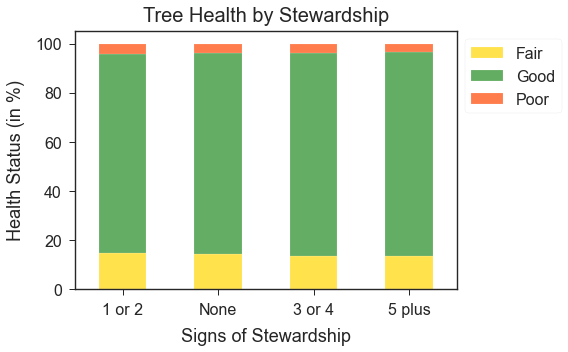

In [89]:
# prepare data for stacked bar, sort by percentage of trees in good health
stewards = trees.groupby(['steward']).health.value_counts(normalize=True).unstack().sort_values('Good')

# plot stacked bar graph
p8 = stewards.plot(kind='bar', stacked=True, figsize=(8,5),
                   color=['gold', 'forestgreen', 'orangered'], alpha=0.7)

# prettify the graph
p8.set_title('Tree Health by Stewardship', fontsize=20, pad=10)
p8.set_xlabel('Signs of Stewardship', fontsize=18, labelpad=10)
p8.set_xticklabels(['1 or 2', 'None', '3 or 4', '5 plus'], rotation='horizontal', fontsize=16)
p8.set_ylabel('Health Status (in %)', fontsize=18, labelpad=10)
p8.set_yticklabels([0, 20, 40, 60, 80, 100], fontsize=16)
p8.legend(['Fair','Good', 'Poor'], fontsize=16, bbox_to_anchor=(1,1))

# prepare to save and display
plt.tight_layout()
plt.savefig('images/charts/stewardship_barstack.png', bbox_inches='tight', transparent=True)
plt.show()

- Health status appears very similar across all values, but it is interesting that trees with no signs of stewardship had more in Good health than ones with 1 or 2.

In [90]:
# create a frequency table
df_steward_health = pd.crosstab(trees.health, trees.steward)
df_steward_health

steward,1or2,3or4,5plus,None
health,,,,
Fair,11376,894,93,50685
Good,63090,5551,582,294368
Poor,3253,256,23,14219


In [91]:
# returns 𝜒2 value, p-value, degree of freedom and expected values
stat, p, dof, expected = stats.chi2_contingency(df_steward_health)

# p-value shows significance
p

1.869053616166277e-05

In [92]:
# create a table of standardized residuals; anything over +/-1.96 shows significance
table = sm.stats.Table(df_steward_health)
table.standardized_resids

steward,1or2,3or4,5plus,None
health,,,,
Fair,3.956465,-2.000492,-0.654533,-3.133921
Good,-5.100084,2.182166,1.071539,4.139673
Poor,2.995387,-0.733479,-0.944229,-2.569387


In [93]:
# percentage of significant values
abs_table = table.standardized_resids.apply(lambda x: abs(x))
print(f'{round((abs_table[abs_table > 1.96].count().sum() / abs_table.count().sum()) * 100, 2)}%')

66.67%


- Almost 50-50, but still something to consider.
- What about tree guards?

In [94]:
# look at breakdown of tree guard quality
trees.guards.value_counts()

None       413018
Helpful     21896
Harmful      6222
Unsure       3254
Name: guards, dtype: int64

In [95]:
# take a look at health values
trees.groupby('guards').health.value_counts(normalize=True)

guards   health
Harmful  Good      0.763581
         Fair      0.183864
         Poor      0.052555
Helpful  Good      0.831339
         Fair      0.129156
         Poor      0.039505
None     Good      0.818657
         Fair      0.141691
         Poor      0.039652
Unsure   Good      0.773510
         Fair      0.170559
         Poor      0.055931
Name: health, dtype: float64

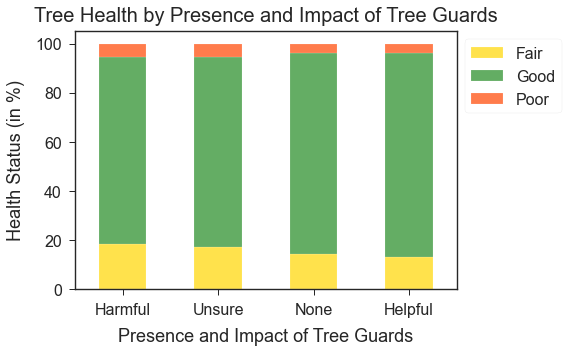

In [96]:
# prepare data for stacked bar, sort by percentage of trees in good health
guards = trees.groupby(['guards']).health.value_counts(normalize=True).unstack().sort_values('Good')

# plot stacked bar graph
p9 = guards.plot(kind='bar', stacked=True, figsize=(8,5),
                   color=['gold', 'forestgreen', 'orangered'], alpha=0.7)

# prettify the graph
p9.set_title('Tree Health by Presence and Impact of Tree Guards', fontsize=20, pad=10)
p9.set_xlabel('Presence and Impact of Tree Guards', fontsize=18, labelpad=10)
p9.set_xticklabels(['Harmful', 'Unsure', 'None', 'Helpful'], rotation='horizontal', fontsize=16)
p9.set_ylabel('Health Status (in %)', fontsize=18, labelpad=10)
p9.set_yticklabels([0, 20, 40, 60, 80, 100], fontsize=16)
p9.legend(['Fair','Good', 'Poor'], fontsize=16, bbox_to_anchor=(1,1))

# prepare to save and display
plt.tight_layout()
plt.savefig('images/charts/tree_guards_barstack.png', bbox_inches='tight', transparent=True)
plt.show()

- Health status appears affected by tree guards.

In [97]:
# create a frequency table
df_guards_health = pd.crosstab(trees.health, trees.guards)
df_guards_health

guards,Harmful,Helpful,None,Unsure
health,,,,
Fair,1144,2828,58521,555
Good,4751,18203,338120,2517
Poor,327,865,16377,182


In [98]:
# returns 𝜒2 value, p-value, degree of freedom and expected values
stat, p, dof, expected = stats.chi2_contingency(df_guards_health)

# p-value shows significance
p

3.966671702516975e-41

In [99]:
# create a table of standardized residuals; anything over +/-1.96 shows significance
table = sm.stats.Table(df_guards_health)
table.standardized_resids

guards,Harmful,Helpful,None,Unsure
health,,,,
Fair,9.559314,-5.532114,-1.277027,4.706680
Good,-11.245203,5.177672,2.990337,-6.631010
Poor,5.115549,-0.340756,-3.614263,4.673919


In [100]:
# percentage of significant values
abs_table = table.standardized_resids.apply(lambda x: abs(x))
print(f'{round((abs_table[abs_table > 1.96].count().sum() / abs_table.count().sum()) * 100, 2)}%')

83.33%


- Definitely some significance here.

## Vanilla models interruption
[[go back to the top](#Verifying-Volunteer-Entries-to-the-NYC-Trees-Census)]
- Since I've gotten through all of the variables that were basically ready-made, now is a good opportunity to look at a starting point for our model.
- Using only the variables that came with the dataset (i.e. the one continuous variable and the variables that were already in only two categories), I'll build vanilla Naive Bayes and Random Forest models.

In [101]:
# set columns as features that came more or less ready-made, i.e. nothing I engineered or have to fully dummy
prelim_features = ['tree_diameter', 'on_curb', 'sidewalk_damage', 'root_stone', 'root_grate', 'root_other',
                   'trunk_wire', 'trunk_light', 'trunk_other', 'branch_light', 'branch_shoe', 'branch_other']

In [102]:
trees.columns

Index(['tree_diameter', 'on_curb', 'health', 'species', 'steward', 'guards',
       'sidewalk_damage', 'root_stone', 'root_grate', 'root_other',
       'trunk_wire', 'trunk_light', 'trunk_other', 'branch_light',
       'branch_shoe', 'branch_other', 'cb_num', 'boroname', 'council_dist',
       'st_assembly', 'st_senate', 'nta', 'log_block_count', 'neighbor_dist'],
      dtype='object')

In [103]:
# create x and y values
X_van = trees[prelim_features]
y_van = trees['health']

In [104]:
# train-test split
X_train_van, X_test_van, y_train_van, y_test_van = train_test_split(X_van, y_van, random_state=42, stratify=y_van)

# use a scaler so we can get the continuous variable on the same scale
scaler = StandardScaler()  
scaler.fit(X_train_van)

# transform x sets
X_train_van = scaler.transform(X_train_van) 
X_test_van = scaler.transform(X_test_van)

#### Custom scoring function
- Since there is a tendency to overpredict the majority class, comparing the precision of "Good" predictions will be a helpful metric to determine the success of a model.
    - See the [functions.py](functions.py) file to look at how it's calculated.

#### Vanilla Naive Bayes

In [105]:
# create Gaussian Naive Bayes object with prior probabilities of each class--Fair, Good, Poor
van_gnb = GaussianNB()

# train model
van_ganaba = van_gnb.fit(X_train_van, y_train_van)

# predict on test data
van_pred_ganaba = van_ganaba.predict(X_test_van)

# check accuracy
print('Test Accuracy score: ', accuracy_score(y_test_van, van_pred_ganaba))
# check f1
print('Test F1 score: ', f1_score(y_test_van, van_pred_ganaba, average='weighted'))
# check recall
print('Test Recall score: ', recall_score(y_test_van, van_pred_ganaba, average='weighted'))
# check precision
print('Test Precision score: ', precision_score(y_test_van, van_pred_ganaba, average='weighted'))
# check custom good precision
print('Test "Good" Precision score: ', good_precision(y_test_van, van_pred_ganaba))

Test Accuracy score:  0.7814452105348431
Test F1 score:  0.7397053095044618
Test Recall score:  0.7814452105348431
Test Precision score:  0.7173633834053238
Test "Good" Precision score:  0.8339684959349594


#### Confusion matrix

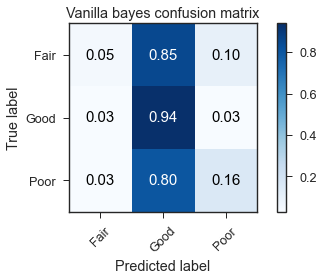

In [106]:
cm_van = confusion_matrix(y_test_van, van_pred_ganaba)
classes = ['Fair', 'Good', 'Poor']

plot_confusion_matrix(cm_van, classes,
                          normalize=True,
                          title='Vanilla bayes confusion matrix',
                          cmap=plt.cm.Blues)

- Very heavily predicted majority class, as any good baseline model should.

#### Vanilla Random Forest

In [107]:
# vanilla random forest
van_forest = RandomForestClassifier(class_weight='balanced', random_state=99, n_jobs=-1)

# fit training data
van_forest.fit(X_train_van, y_train_van)

# predict on test data
van_pred_forest = van_forest.predict(X_test_van)

# check accuracy
print('Test Accuracy score: ', accuracy_score(y_test_van, van_pred_forest))
# check f1
print('Test F1 score: ', f1_score(y_test_van, van_pred_forest, average='weighted'))
# check recall
print('Test Recall score: ', recall_score(y_test_van, van_pred_forest, average='weighted'))
# check precision
print('Test Precision score: ', precision_score(y_test_van, van_pred_forest, average='weighted'))
# check custom good precision
print('Test "Good" Precision score: ', good_precision(y_test_van, van_pred_forest))

Test Accuracy score:  0.5467515166789682
Test F1 score:  0.6144756656921714
Test Recall score:  0.5467515166789682
Test Precision score:  0.7231190729636647
Test "Good" Precision score:  0.8481540444242286


- Much worse in terms of accuracy, though the "Good" precision is better. Maybe the confusion matrix will tell a more nuanced story.

#### Confusion matrix

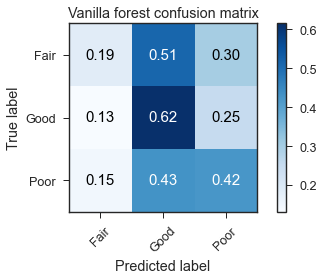

In [108]:
cm_van = confusion_matrix(y_test_van, van_pred_forest)
classes = ['Fair', 'Good', 'Poor']

plot_confusion_matrix(cm_van, classes,
                          normalize=True,
                          title='Vanilla forest confusion matrix',
                          cmap=plt.cm.Blues)

- Definitely a more even spread of predictions, which is closer to what I'm looking for. Although I generally prefer F1 score so I can take both false positives and false negatives into account, it appears "Good" precision may be the most useful statistic.
- I'll take a look at which features proved important.

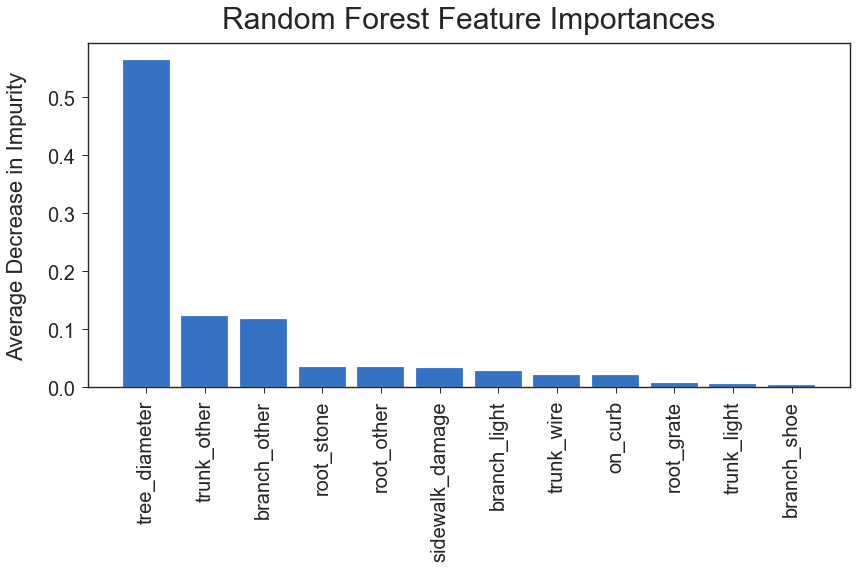

[('tree_diameter', 0.5649296734480588), ('trunk_other', 0.12291411749107814), ('branch_other', 0.11832189404593137), ('root_stone', 0.035311548387537965), ('root_other', 0.03520734891611893), ('sidewalk_damage', 0.033643113702809896), ('branch_light', 0.028395460637136053), ('trunk_wire', 0.021973037182913976), ('on_curb', 0.021786641662018956), ('root_grate', 0.007471545986653303), ('trunk_light', 0.006392380463796642), ('branch_shoe', 0.003653238075945942)]


In [109]:
plot_forest_features(van_forest, X_van, num_features=X_van.shape[1])

- Some surprises here:
    - Tree diameter topped the list by a large margin.
    - Many of the categorical variables hold fairly equal importance.
- I'll keep all these in the mix for now and see how they perform in my final model.

## Finishing up dummy columns
[[go back to the top](#Verifying-Volunteer-Entries-to-the-NYC-Trees-Census)]

- Now I'll finish making all the features for variables that have more than two categories.

In [110]:
# choose columns to dummy (again, going ahead with community board as area proxy column)
dummy_cols = ['steward', 'guards', 'boroname', 'cb_num', 'species']

# convert community board column to string so I can easily dummy it
trees['cb_num'] = trees.cb_num.astype(str)

In [111]:
# dummy
tree_dummies = pd.get_dummies(trees[dummy_cols])

# reformat
tree_dummies.columns = [col.replace(' ', '_').replace("'", "") for col in list(tree_dummies.columns)]

# check work
tree_dummies.columns

Index(['steward_1or2', 'steward_3or4', 'steward_5plus', 'steward_None',
       'guards_Harmful', 'guards_Helpful', 'guards_None', 'guards_Unsure',
       'boroname_Bronx', 'boroname_Brooklyn',
       ...
       'species_silver_maple', 'species_sugar_maple',
       'species_swamp_white_oak', 'species_sweetgum', 'species_sycamore_maple',
       'species_tree_of_heaven', 'species_tulip-poplar', 'species_white_ash',
       'species_white_oak', 'species_willow_oak'],
      dtype='object', length=138)

- To avoid multicollinearity, I have to drop a dummy column from each of these variables, which I'll do alongside the pre-dummied columns themselves.

In [112]:
# add onto the dummy_cols list, so I can drop the pre-dummied columns, plus a dummy from each,
# plus the columns I no longer need
dummy_cols.extend(['steward_None', 'guards_None', 'boroname_Staten_Island', 'cb_num_101', 'species_Other',
                  'council_dist', 'st_assembly', 'st_senate', 'nta'])

In [113]:
# combine dataframe and dummy columns
trees_full = pd.concat([trees, tree_dummies], axis=1)

# drop columns
trees_full.drop(columns=dummy_cols, axis=1, inplace=True)

# check
trees_full.columns

Index(['tree_diameter', 'on_curb', 'health', 'sidewalk_damage', 'root_stone',
       'root_grate', 'root_other', 'trunk_wire', 'trunk_light', 'trunk_other',
       ...
       'species_silver_maple', 'species_sugar_maple',
       'species_swamp_white_oak', 'species_sweetgum', 'species_sycamore_maple',
       'species_tree_of_heaven', 'species_tulip-poplar', 'species_white_ash',
       'species_white_oak', 'species_willow_oak'],
      dtype='object', length=148)

In [114]:
# uncomment to save
trees_full.to_csv('data/nyc_trees_final.csv')

# uncomment to load
trees_full = pd.read_csv('data/nyc_trees_final.csv', index_col=0)

In [115]:
trees_full.head()

,tree_diameter,on_curb,health,sidewalk_damage,root_stone,root_grate,root_other,trunk_wire,trunk_light,trunk_other,...,species_silver_maple,species_sugar_maple,species_swamp_white_oak,species_sweetgum,species_sycamore_maple,species_tree_of_heaven,species_tulip-poplar,species_white_ash,species_white_oak,species_willow_oak
0,3.0,1,Fair,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
57,3.0,1,Good,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59,10.0,1,Good,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60,6.0,1,Good,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
123,10.0,1,Good,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## Train-test split and modeling

In [116]:
# create features and target
X = trees_full.drop(columns=['health'], axis=1)
y = trees_full['health']

In [117]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# use a scaler so we can get the two continuous variables on the same scale
scaler = StandardScaler()  
scaler.fit(X_train)

X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)

### Naive Bayes - Gaussian

In [118]:
# create Gaussian Naive Bayes object
gnb = GaussianNB()

# train model
ganaba = gnb.fit(X_train, y_train)

# predict on test data
y_pred_gnb = ganaba.predict(X_test)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_gnb))
# checking f1
print('Test F1 score: ', f1_score(y_test, y_pred_gnb, average='weighted'))
# checking recall
print('Test Recall score: ', recall_score(y_test, y_pred_gnb, average='weighted'))
# checking precision
print('Test Precision score: ', precision_score(y_test, y_pred_gnb, average='weighted'))
# check custom good precision
print('Test "Good" Precision score: ', good_precision(y_test, y_pred_gnb))

Test Accuracy score:  0.642666834686493
Test F1 score:  0.6809288574580357
Test Recall score:  0.642666834686493
Test Precision score:  0.7317499357430028
Test "Good" Precision score:  0.8530982974416788


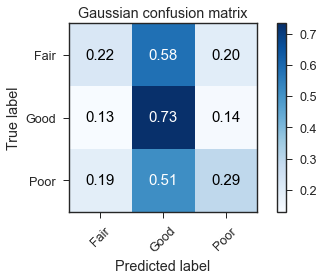

In [119]:
cm_gnb = confusion_matrix(y_test, y_pred_gnb)
classes = ['Fair', 'Good', 'Poor']

plot_confusion_matrix(cm_gnb, classes,
                          normalize=True,
                          title='Gaussian confusion matrix',
                          cmap=plt.cm.Blues)

- **Not too shabby for something that takes all of ten seconds to run.**
- **Decent spread of predictions, though I'd like to increase true positives for every category.**

### Naive Bayes - Bernoulli

In [120]:
# create Bernoulli Naive Bayes object
bnb = BernoulliNB()

# train model
banaba = bnb.fit(X_train, y_train)

# predict on test data
y_pred_bnb = banaba.predict(X_test)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_bnb))
# checking f1
print('Test F1 score: ', f1_score(y_test, y_pred_bnb, average='weighted'))
# checking recall
print('Test Recall score: ', recall_score(y_test, y_pred_bnb, average='weighted'))
# checking precision
print('Test Precision score: ', precision_score(y_test, y_pred_bnb, average='weighted'))
# check custom good precision
print('Test "Good" Precision score: ', good_precision(y_test, y_pred_bnb))

Test Accuracy score:  0.8172334335451583
Test F1 score:  0.7482643829713552
Test Recall score:  0.8172334335451583
Test Precision score:  0.7399639802344163
Test "Good" Precision score:  0.8253529126169123


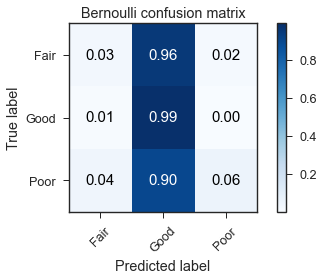

In [121]:
cm_bnb = confusion_matrix(y_test, y_pred_bnb)
classes = ['Fair', 'Good', 'Poor']

plot_confusion_matrix(cm_bnb, classes,
                          normalize=True,
                          title='Bernoulli confusion matrix',
                          cmap=plt.cm.Blues)

- **Not a very helpful model, as it almost entirely predicts the dominant class.**

### Decision Tree - untuned

In [122]:
# basic decision tree with class weights balanced
tree = DecisionTreeClassifier(class_weight='balanced', random_state=99)

# fit training data
tree.fit(X_train, y_train)

# predict on test data
y_pred_tree = tree.predict(X_test)

# check accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_tree))
# check f1
print('Test F1 score: ', f1_score(y_test, y_pred_tree, average='weighted'))
# check recall
print('Test Recall score: ', recall_score(y_test, y_pred_tree, average='weighted'))
# check precision
print('Test Precision score: ', precision_score(y_test, y_pred_tree, average='weighted'))
# check custom good precision
print('Test "Good" Precision score: ', good_precision(y_test, y_pred_tree))

Test Accuracy score:  0.7293650650776792
Test F1 score:  0.7341546924634719
Test Recall score:  0.7293650650776792
Test Precision score:  0.7392077290359782
Test "Good" Precision score:  0.8533127094612013


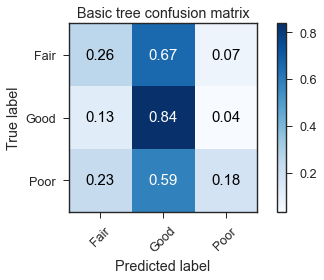

In [123]:
cm_tree = confusion_matrix(y_test, y_pred_tree)
classes = ['Fair', 'Good', 'Poor']

plot_confusion_matrix(cm_tree, classes,
                          normalize=True,
                          title='Basic tree confusion matrix',
                          cmap=plt.cm.Blues)

- **A definite step in the right direction, though the true positives for 'Poor' has a worse rate than the Naive Bayes model.**

### Random Forest - untuned

In [124]:
# basic random forest with class weights balanced
forest = RandomForestClassifier(class_weight='balanced', random_state=99, n_jobs=-1)

# fit training data
forest.fit(X_train, y_train)

# predict on test data
y_pred_forest = forest.predict(X_test)

# check accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_forest))
# check f1
print('Test F1 score: ', f1_score(y_test, y_pred_forest, average='weighted'))
# check recall
print('Test Recall score: ', recall_score(y_test, y_pred_forest, average='weighted'))
# check precision
print('Test Precision score: ', precision_score(y_test, y_pred_forest, average='weighted'))
# check custom good precision
print('Test "Good" Precision score: ', good_precision(y_test, y_pred_forest))

Test Accuracy score:  0.8211578966318025
Test F1 score:  0.7781361229391482
Test Recall score:  0.8211578966318025
Test Precision score:  0.772408890339714
Test "Good" Precision score:  0.843262431650969


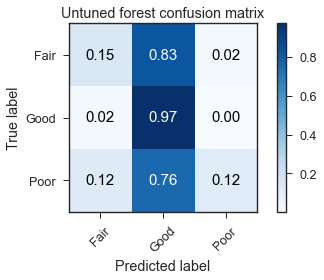

In [125]:
# confusion matrix - normalized
cm = confusion_matrix(y_test, y_pred_forest)
classes = ['Fair', 'Good', 'Poor']

plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Untuned forest confusion matrix',
                          cmap=plt.cm.Blues)

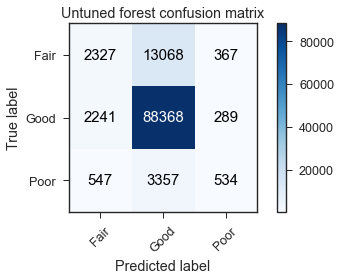

In [126]:
# confusion matrix - totals
cm = confusion_matrix(y_test, y_pred_forest)
classes = ['Fair', 'Good', 'Poor']

plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Untuned forest confusion matrix',
                          cmap=plt.cm.Blues)

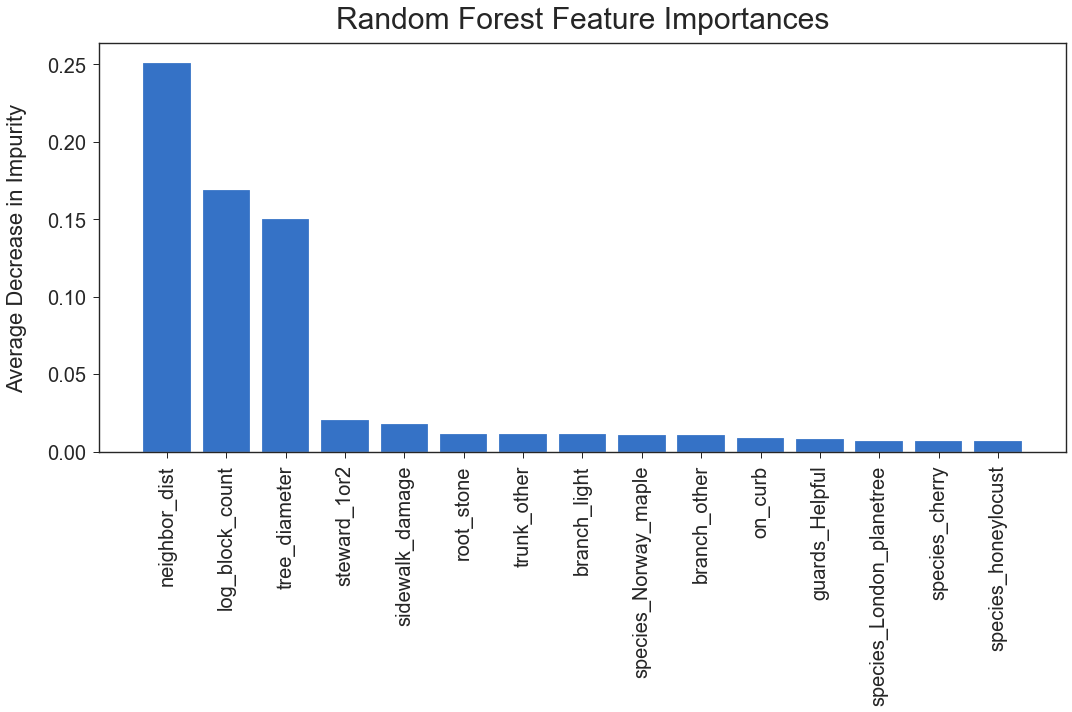

[('neighbor_dist', 0.25097254062797764), ('log_block_count', 0.16902474592676983), ('tree_diameter', 0.1503946752986133), ('steward_1or2', 0.02014602693340981), ('sidewalk_damage', 0.017796827978822174), ('root_stone', 0.011422310174856386), ('trunk_other', 0.011392350694567102), ('branch_light', 0.011023510304993189), ('species_Norway_maple', 0.01088481362812499), ('branch_other', 0.010459063388982115), ('on_curb', 0.008929256621971637), ('guards_Helpful', 0.00831170822812112), ('species_London_planetree', 0.0071185405782754445), ('species_cherry', 0.006879274740154849), ('species_honeylocust', 0.006776665076999079)]


In [127]:
# feature importances
plot_forest_features(forest, X)

- **Definitely better than the Bernoulli Naive Bayes model, but perhaps a bit too similar.**
- **I'd like to spread the predictions out and increase true positives for 'Fair' and 'Poor' predictions.**

### Tuned Random Forest - tuned (original trial and error)

In [128]:
%%time

# random forest
forest_tuned = RandomForestClassifier(max_features=11,
                                      min_samples_leaf=3,
                                      class_weight='balanced',
                                      random_state=99, n_jobs=-1,
                                      n_estimators=100
                                      )

# fit training data
forest_tuned.fit(X_train, y_train)

# predict on test data
y_pred_forest_tuned = forest_tuned.predict(X_test)

# check accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_forest_tuned))
# check f1
print('Test F1 score: ', f1_score(y_test, y_pred_forest_tuned, average='weighted'))
# check recall
print('Test Recall score: ', recall_score(y_test, y_pred_forest_tuned, average='weighted'))
# check precision
print('Test Precision score: ', precision_score(y_test, y_pred_forest_tuned, average='weighted'))
# check custom good precision
print('Test "Good" Precision score: ', good_precision(y_test, y_pred_forest_tuned))

Test Accuracy score:  0.7248825361392645
Test F1 score:  0.7465547536959304
Test Recall score:  0.7248825361392645
Test Precision score:  0.7750750052752584
Test "Good" Precision score:  0.8866297353524603
CPU times: user 3min 49s, sys: 1.26 s, total: 3min 51s
Wall time: 34 s


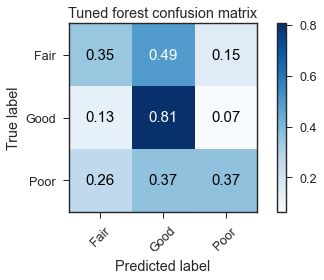

In [129]:
# confusion matrix - normalized
cm_tuned = confusion_matrix(y_test, y_pred_forest_tuned)
classes = ['Fair', 'Good', 'Poor']

plot_confusion_matrix(cm_tuned, classes,
                          normalize=True,
                          title='Tuned forest confusion matrix',
                          cmap=plt.cm.Blues)

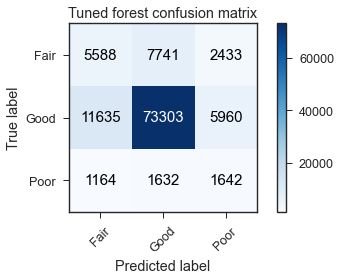

In [130]:
# confusion matrix - totals
cm_tuned = confusion_matrix(y_test, y_pred_forest_tuned)
classes = ['Fair', 'Good', 'Poor']

plot_confusion_matrix(cm_tuned, classes,
                          normalize=False,
                          title='Tuned forest confusion matrix',
                          cmap=plt.cm.Blues)

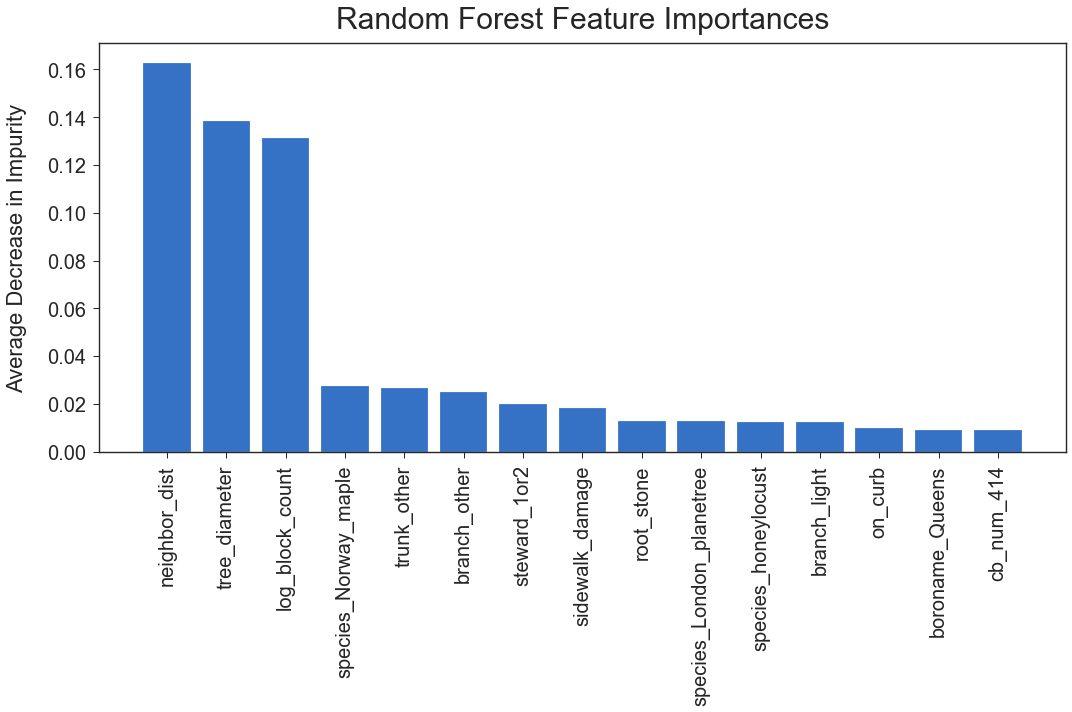

[('neighbor_dist', 0.16278667203624866), ('tree_diameter', 0.1382727841117844), ('log_block_count', 0.13143765655012318), ('species_Norway_maple', 0.027614153753232985), ('trunk_other', 0.026675209255690207), ('branch_other', 0.02483337551315112), ('steward_1or2', 0.01980721304856252), ('sidewalk_damage', 0.018255914262261946), ('root_stone', 0.012846468036890562), ('species_London_planetree', 0.012807927119922244), ('species_honeylocust', 0.012509801172976225), ('branch_light', 0.012378202619472391), ('on_curb', 0.009707016045440638), ('boroname_Queens', 0.008953766775986633), ('cb_num_414', 0.008860927401522011)]


In [131]:
# feature importances
plot_forest_features(forest_tuned, X)

- **This is definitely more what I had in mind. Big hit on true positives for 'Good' predictions, but a much better spread among the other two categories.**
- **I'll see if I can fine tune this with a focused GridSearch.**

### Random Forest - with GridSearch
- **I'll be using my custom scoring function to evaluate the search.**

In [132]:
# use sklearn's make_scorer to get my custom function into the correct format
my_scorer = make_scorer(good_precision, greater_is_better=True)

In [133]:
# create parameter options
param_grid = {
    'max_depth': [25, 50, 75, 100, None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [100]
}

In [134]:
%%time
# create base model to tune
rf = RandomForestClassifier(class_weight='balanced', random_state=99)

# using 3 fold cross validation, search across 135 different combinations, and use all available cores
rf_grid = GridSearchCV(estimator=rf, param_grid=param_grid, scoring=my_scorer, cv=3, 
                       n_jobs=-1, verbose=2)

# Fit the random search model
rf_grid.fit(X_train, y_train)

Fitting 3 folds for each of 45 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 64.6min finished


CPU times: user 1min 14s, sys: 1.6 s, total: 1min 15s
Wall time: 1h 5min 44s


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=99,
                            

In [135]:
# examine the best model

# single best score achieved across all params
print(rf_grid.best_score_)

# dictionary containing the parameters used to generate that score
print(rf_grid.best_params_)

# actual model object fit with those best parameters
# shows default parameters that I did not specify
print(rf_grid.best_estimator_)

0.885967458292495
{'max_depth': 25, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=25, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=99, verbose=0,
                       warm_start=False)


In [136]:
# predict on test data using best model
y_pred_rf_grid = rf_grid.best_estimator_.predict(X_test)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_rf_grid))
# checking f1
print('Test F1 score: ', f1_score(y_test, y_pred_rf_grid, average='weighted'))
# checking recall
print('Test Recall score: ', recall_score(y_test, y_pred_rf_grid, average='weighted'))
# checking precision
print('Test Precision score: ', precision_score(y_test, y_pred_rf_grid, average='weighted'))
# check custom good precision
print('Test "Good" Precision score: ', good_precision(y_test, y_pred_rf_grid))

Test Accuracy score:  0.6366451241246467
Test F1 score:  0.6884134652932417
Test Recall score:  0.6366451241246467
Test Precision score:  0.7692944575983606
Test "Good" Precision score:  0.8893642604476881


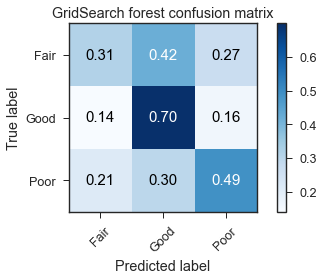

In [137]:
# confusion matrix - normalized
cm_grid = confusion_matrix(y_test, y_pred_rf_grid)
classes = ['Fair', 'Good', 'Poor']

plot_confusion_matrix(cm_grid, classes,
                          normalize=True,
                          title='GridSearch forest confusion matrix',
                          cmap=plt.cm.Blues)

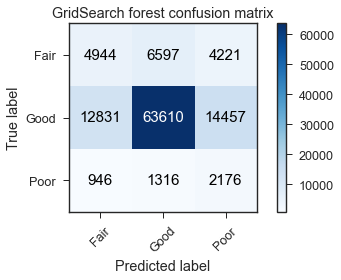

In [138]:
# confusion matrix - totals
cm_grid = confusion_matrix(y_test, y_pred_rf_grid)
classes = ['Fair', 'Good', 'Poor']

plot_confusion_matrix(cm_grid, classes,
                          normalize=False,
                          title='GridSearch forest confusion matrix',
                          cmap=plt.cm.Blues)

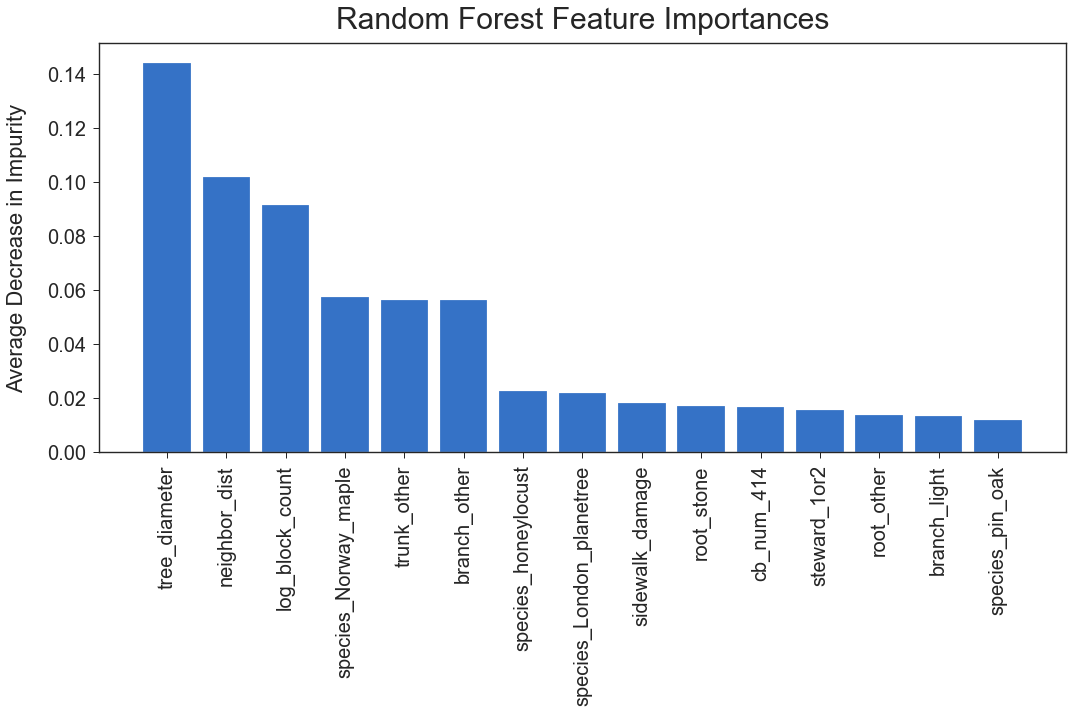

[('tree_diameter', 0.14406371620357872), ('neighbor_dist', 0.10178931129504715), ('log_block_count', 0.09128551871691462), ('species_Norway_maple', 0.05738445626911563), ('trunk_other', 0.056161457841156726), ('branch_other', 0.056137688211247205), ('species_honeylocust', 0.02236877388130019), ('species_London_planetree', 0.021522932568601546), ('sidewalk_damage', 0.017958628951076847), ('root_stone', 0.017001469555143187), ('cb_num_414', 0.016458578196397667), ('steward_1or2', 0.0153584136236691), ('root_other', 0.013375631884285293), ('branch_light', 0.01320355181139191), ('species_pin_oak', 0.01155430116664602)]


In [139]:
# feature importances
plot_forest_features(rf_grid.best_estimator_, X)

- **These results give me a bit more to work off of in terms of hyperparameter tuning.**
- **Still, I'd like to keep true positives for 'Good' to at least 80% without much sacrifice in the other categories.**

### Tuned Random Forest - retuned (trial and error post-GridSearch)

In [140]:
# random forest
forest_retuned = RandomForestClassifier(max_features=11,
#                                       max_depth=60,
                                      min_samples_leaf=2,
                                      min_samples_split=11,
                                      class_weight='balanced',
                                      random_state=99, n_jobs=-1,
                                      n_estimators=500
                                      )

# fit training data
forest_retuned.fit(X_train, y_train)

# predict on test data
y_pred_forest_retuned = forest_retuned.predict(X_test)

# check accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_forest_retuned))
# check f1
print('Test F1 score: ', f1_score(y_test, y_pred_forest_retuned, average='weighted'))
# check recall
print('Test Recall score: ', recall_score(y_test, y_pred_forest_retuned, average='weighted'))
# check precision
print('Test Precision score: ', precision_score(y_test, y_pred_forest_retuned, average='weighted'))
# check custom good precision
print('Test "Good" Precision score: ', good_precision(y_test, y_pred_forest_retuned))

Test Accuracy score:  0.7467641181659436
Test F1 score:  0.7603101510453832
Test Recall score:  0.7467641181659436
Test Precision score:  0.7768794601022634
Test "Good" Precision score:  0.8844439777871109


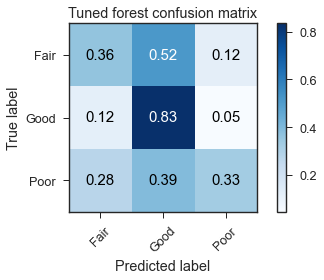

In [141]:
# confusion matrix - normalized
cm_retuned = confusion_matrix(y_test, y_pred_forest_retuned)
classes = ['Fair', 'Good', 'Poor']

plot_confusion_matrix(cm_retuned, classes,
                          normalize=True,
                          title='Tuned forest confusion matrix',
                          cmap=plt.cm.Blues)

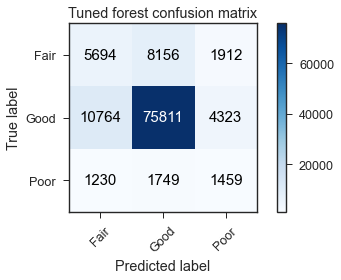

In [142]:
# confusion matrix - totals
cm_retuned = confusion_matrix(y_test, y_pred_forest_retuned)
classes = ['Fair', 'Good', 'Poor']

plot_confusion_matrix(cm_retuned, classes,
                          normalize=False,
                          title='Tuned forest confusion matrix',
                          cmap=plt.cm.Blues)

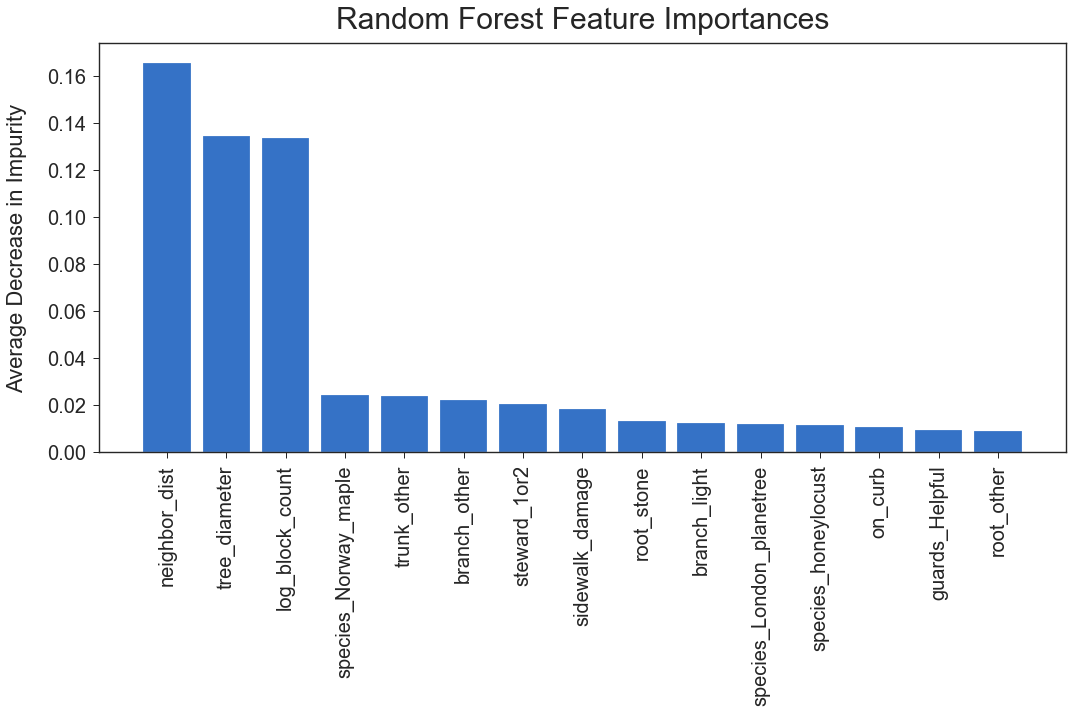

[('neighbor_dist', 0.16542015797203735), ('tree_diameter', 0.13444514456922024), ('log_block_count', 0.13363713298282787), ('species_Norway_maple', 0.024049260717340478), ('trunk_other', 0.023467397930798675), ('branch_other', 0.022074995557074147), ('steward_1or2', 0.02035111226823292), ('sidewalk_damage', 0.018210276238579192), ('root_stone', 0.013093467774278212), ('branch_light', 0.01213940998877915), ('species_London_planetree', 0.011777898987209875), ('species_honeylocust', 0.011146535583966784), ('on_curb', 0.010422752773151208), ('guards_Helpful', 0.009285493155989474), ('root_other', 0.008700475465041978)]


In [143]:
# feature importances
plot_forest_features(forest_retuned, X)

- **This is where it stands for now.**
- **I'm decently happy with these results; seems like the best spread of the bunch while still keeping 'Good' true positives at a respectable 85%.**

### Save best model
- **Pickle it using gzip.**

In [144]:
# # uncomment to save
# with gzip.open('data/final_model.pickle', 'wb') as goodbye:
#     pickle.dump(forest_retuned, goodbye, protocol=pickle.HIGHEST_PROTOCOL)

# # uncomment to load
# with gzip.open('data/final_model.pickle', 'rb') as hello:
#     model = pickle.load(hello)

# Final conclusion
##### I can run my final model on the data collected by volunteers and compile a list of trees that whose health statuses do not line up. In the meantime, the NYC Street Trees Census is fairly thorough and rife with opportunities for data exploration and predictive modeling. Perhaps with a neural network, I could greatly improve my model. In future censuses, even more data could be gathered (especially in regard to specificity of tree problems) that will increase these opportunities for prediction even further.